# Crime ML

We show that using time and location based features along with deep neural nets and transformers provide superior model performance compared to state of the art for Crime Prediction with 40% improvements of 5-10% higher accuracies

Make sure to place your cartodb-query.csv from https://data.phila.gov/visualizations/crime-incidents in the data folder to run the project. You can always rerun everything with updated rows of data and the code will handle it

In [1]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import OrdinalEncoder, OneHotEncoder, StandardScaler, LabelEncoder
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from datetime import datetime
import matplotlib.pyplot as plt

In [59]:
crimes = pd.read_csv('cartodb-query.csv')
data = crimes[["dispatch_date", "dispatch_time","location_block", "text_general_code", "point_x", "point_y"]]

In [60]:
data.head()

,dispatch_date,dispatch_time,location_block,text_general_code,point_x,point_y
0,2024-01-05,23:55:00,2100 BLOCK N BROAD ST,Thefts,-75.155601,39.985841
1,2024-01-05,23:37:00,4100 BLOCK GREEBY ST,Other Assaults,-75.054813,40.029137
2,2024-01-05,23:34:00,2100 BLOCK S 67TH ST,Other Assaults,-75.237863,39.924887
3,2024-01-05,23:29:00,3200 BLOCK N NEWKIRK ST,Vandalism/Criminal Mischief,-75.175303,40.005423
4,2024-01-05,23:27:00,5200 BLOCK N HOWARD ST,Theft from Vehicle,-75.123783,40.029434


# Feature Preprocessing

In [61]:
# The x,y coordinate should already numerically represent the street name
data.drop(columns =["location_block"], axis=1, inplace=True)

C:\Users\Alex Zavalny\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.8_qbz5n2kfra8p0\LocalCache\local-packages\Python38\site-packages\pandas\core\frame.py:4901: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(


In [62]:
data['dispatch_date'] = pd.to_datetime(data['dispatch_date'])
data['dispatch_time'] = pd.to_datetime(data['dispatch_time'], format='%H:%M:%S').dt.time

# Combine date and time into a single DateTime column
data['DateTime'] = pd.to_datetime(data['dispatch_date'].astype(str) + ' ' + data['dispatch_time'].astype(str))

# Extracting features
data['Year'] = data['DateTime'].dt.year
data['Month'] = data['DateTime'].dt.month
data['Day'] = data['DateTime'].dt.day
data['Hour'] = data['DateTime'].dt.hour
data['Minute'] = data['DateTime'].dt.minute
data['Weekday'] = data['DateTime'].dt.weekday  # Monday=0, Sunday=6

C:\Users\Alex Zavalny\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.8_qbz5n2kfra8p0\LocalCache\local-packages\Python38\site-packages\pandas\core\frame.py:3607: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._set_item(key, value)


In [63]:
data_copy = data
data_copy["dispatch_date"] = data_copy["dispatch_date"].dt.strftime('%Y-%m')
unemp = pd.read_csv("unemployment rate.csv")
unemp.rename(columns={"label":"dispatch_date", "Unemployment Rate of a Population":"Unemployment_Rate"}, inplace=True)

data = pd.merge(data_copy, unemp, on="dispatch_date", how="left")

In [64]:
data["Unemployment_Rate"] = data["Unemployment_Rate"].fillna(unemp.iloc[0, 1])

In [65]:
data.drop(columns=["dispatch_date", "dispatch_time"], axis=1, inplace=True)
data.head()

,text_general_code,point_x,point_y,DateTime,Year,Month,Day,Hour,Minute,Weekday,Unemployment_Rate
0,Thefts,-75.155601,39.985841,2024-01-05 23:55:00,2024,1,5,23,55,4,5.4
1,Other Assaults,-75.054813,40.029137,2024-01-05 23:37:00,2024,1,5,23,37,4,5.4
2,Other Assaults,-75.237863,39.924887,2024-01-05 23:34:00,2024,1,5,23,34,4,5.4
3,Vandalism/Criminal Mischief,-75.175303,40.005423,2024-01-05 23:29:00,2024,1,5,23,29,4,5.4
4,Theft from Vehicle,-75.123783,40.029434,2024-01-05 23:27:00,2024,1,5,23,27,4,5.4


In [66]:
data.drop(columns=["DateTime"], axis=1, inplace=True)

In [67]:
data.head()

,text_general_code,point_x,point_y,Year,Month,Day,Hour,Minute,Weekday,Unemployment_Rate
0,Thefts,-75.155601,39.985841,2024,1,5,23,55,4,5.4
1,Other Assaults,-75.054813,40.029137,2024,1,5,23,37,4,5.4
2,Other Assaults,-75.237863,39.924887,2024,1,5,23,34,4,5.4
3,Vandalism/Criminal Mischief,-75.175303,40.005423,2024,1,5,23,29,4,5.4
4,Theft from Vehicle,-75.123783,40.029434,2024,1,5,23,27,4,5.4


One Hot Encoding Crime Type, since there is no inherent order in the crime types

In [68]:
data.rename(columns={'text_general_code':'crime_type'}, inplace=True)
data["crime_type"].value_counts()

All Other Offenses                         570584
Other Assaults                             441913
Thefts                                     441041
Vandalism/Criminal Mischief                302010
Theft from Vehicle                         262863
Narcotic / Drug Law Violations             181038
Fraud                                      178205
Burglary Residential                       123246
Aggravated Assault No Firearm              105173
Motor Vehicle Theft                         95879
Robbery No Firearm                          72342
DRIVING UNDER THE INFLUENCE                 66819
Robbery Firearm                             56659
Aggravated Assault Firearm                  49036
Disorderly Conduct                          44204
Weapon Violations                           39058
Burglary Non-Residential                    36106
Other Sex Offenses (Not Commercialized)     21815
Rape                                        17743
Prostitution and Commercialized Vice        15976


In [69]:
# combining Homicide categories together
data["crime_type"] = data["crime_type"].apply(lambda x: "Homicides" if isinstance(x, str) and "Homicide" in x else x)
data["crime_type"].value_counts()

All Other Offenses                         570584
Other Assaults                             441913
Thefts                                     441041
Vandalism/Criminal Mischief                302010
Theft from Vehicle                         262863
Narcotic / Drug Law Violations             181038
Fraud                                      178205
Burglary Residential                       123246
Aggravated Assault No Firearm              105173
Motor Vehicle Theft                         95879
Robbery No Firearm                          72342
DRIVING UNDER THE INFLUENCE                 66819
Robbery Firearm                             56659
Aggravated Assault Firearm                  49036
Disorderly Conduct                          44204
Weapon Violations                           39058
Burglary Non-Residential                    36106
Other Sex Offenses (Not Commercialized)     21815
Rape                                        17743
Prostitution and Commercialized Vice        15976


In [70]:
data.head()

,crime_type,point_x,point_y,Year,Month,Day,Hour,Minute,Weekday,Unemployment_Rate
0,Thefts,-75.155601,39.985841,2024,1,5,23,55,4,5.4
1,Other Assaults,-75.054813,40.029137,2024,1,5,23,37,4,5.4
2,Other Assaults,-75.237863,39.924887,2024,1,5,23,34,4,5.4
3,Vandalism/Criminal Mischief,-75.175303,40.005423,2024,1,5,23,29,4,5.4
4,Theft from Vehicle,-75.123783,40.029434,2024,1,5,23,27,4,5.4


# Feature Engineering

Taking care of missing values for point_x and point_y

In [71]:
data.isna().sum()

crime_type               0
point_x              46281
point_y              46281
Year                     0
Month                    0
Day                      0
Hour                     0
Minute                   0
Weekday                  0
Unemployment_Rate        0
dtype: int64

In [72]:
data[data['point_x'].isna()]

,crime_type,point_x,point_y,Year,Month,Day,Hour,Minute,Weekday,Unemployment_Rate
17,Thefts,NaN,NaN,2024,1,5,21,36,4,5.4
18,All Other Offenses,NaN,NaN,2024,1,5,21,28,4,5.4
66,Offenses Against Family and Children,NaN,NaN,2024,1,5,18,34,4,5.4
87,Fraud,NaN,NaN,2024,1,5,17,39,4,5.4
101,Other Assaults,NaN,NaN,2024,1,5,17,1,4,5.4
...,...,...,...,...,...,...,...,...,...,...
3177361,DRIVING UNDER THE INFLUENCE,NaN,NaN,2006,1,1,20,13,6,6.7
3177423,Aggravated Assault No Firearm,NaN,NaN,2006,1,1,18,1,6,6.7
3177466,Thefts,NaN,NaN,2006,1,1,16,3,6,6.7
3177715,DRIVING UNDER THE INFLUENCE,NaN,NaN,2006,1,1,2,54,6,6.7


In [73]:
data.dropna(inplace=True)

Lower correlations help in maintaining the integrity of the model coefficients and their interpretations and indicate that features provide different information. This diversity can improve model performance by allowing the model to capture more aspects of the data.

Using one hot encoding for Crime, because while some crimes are worse than others, and some do have worse charges than others, there's not really a way to rank certain pairs

In [74]:
data['crime_type'] = np.argmax(pd.get_dummies(data['crime_type']).iloc[:, 4:].values, axis=1)
data.head()

,crime_type,point_x,point_y,Year,Month,Day,Hour,Minute,Weekday,Unemployment_Rate
0,22,-75.155601,39.985841,2024,1,5,23,55,4,5.4
1,13,-75.054813,40.029137,2024,1,5,23,37,4,5.4
2,13,-75.237863,39.924887,2024,1,5,23,34,4,5.4
3,24,-75.175303,40.005423,2024,1,5,23,29,4,5.4
4,21,-75.123783,40.029434,2024,1,5,23,27,4,5.4


In [75]:
data['crime_type'].unique()

array([22, 13, 24, 21, 20,  0, 25, 18, 19, 11,  1, 10,  6, 12,  2,  5, 14,
       17, 15,  4,  8,  3, 16,  9, 23,  7], dtype=int64)

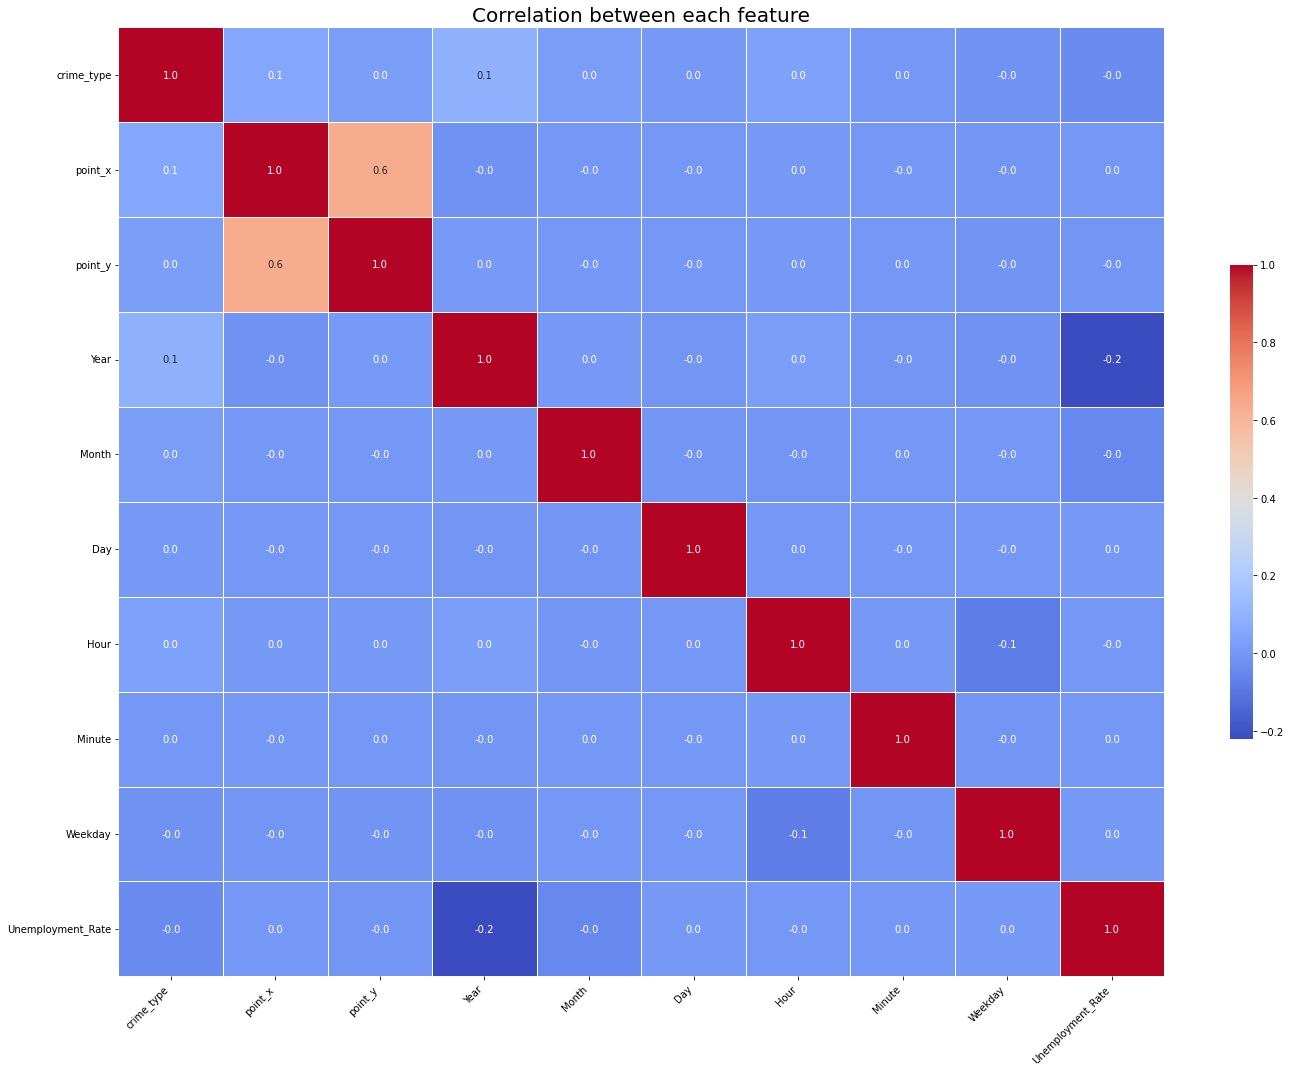

In [76]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt


corr_matrix = data.corr()

plt.figure(figsize=(20, 15))  # Increase figsize to give more room

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".1f", 
            linewidths=.5, cbar_kws={"shrink": .5})

plt.title("Correlation between each feature", fontsize=20)
plt.xticks(rotation=45, ha='right')  # Rotate the x labels for better readability
plt.yticks(rotation=0)  # Keep the y labels horizontal
plt.tight_layout()  # Adjusts plot to ensure everything fits without overlap

# Show plot
plt.show()

In [77]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score  # Importing the accuracy_score function

# Assuming 'data' is your DataFrame with features and 'target_df' is a DataFrame of one-hot encoded targets
X = data.iloc[:, 1:]  # Features
y = data.iloc[:, 0]

# Splitting the dataset into the Training set and Test set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Creating a RandomForestClassifier
model = RandomForestClassifier(n_estimators=50, random_state=42)

Accuracy of the model: 0.20364034072311857


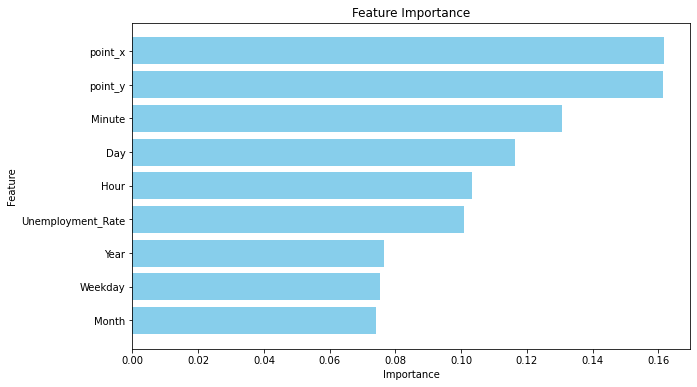

In [78]:
X_train = X_train.sample(n=100000)
y_train = y_train.sample(n=100000)
model.fit(X_train, y_train)

# Predicting the Test set results
y_pred = model.predict(X_test)

# Calculating the accuracy
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy of the model:", accuracy)

# Getting feature importances
importances = model.feature_importances_

# Summarize feature importances in a DataFrame
feature_importances = pd.DataFrame({'feature': X.columns, 'importance': importances})
feature_importances = feature_importances.sort_values(by='importance', ascending=False)

# Plotting the feature importances
plt.figure(figsize=(10, 6))
plt.barh(feature_importances['feature'], feature_importances['importance'], color='skyblue')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.title('Feature Importance')
plt.gca().invert_yaxis()  # Invert y-axis to have the most important at the top
plt.show()

In [79]:
feature_importances

,feature,importance
0,point_x,0.161668
1,point_y,0.161344
6,Minute,0.130590
4,Day,0.116279
5,Hour,0.103334
8,Unemployment_Rate,0.100973
2,Year,0.076388
7,Weekday,0.075352
3,Month,0.074072


In [80]:
feature_data_pipeline = ColumnTransformer([
    ("numerical", StandardScaler(), ["point_x", "point_y","Minute", "Day", "Hour", 
                                     "Unemployment_Rate", "Month", "Weekday", "Year"])
])

In [82]:
X_train.shape, y_train.shape, X_test_encoded.shape, y_test.shape

((2505256, 9), (2505256,), (626315, 9), (626315,))

 # Applying Smote
 This method of rebalancing the classes actually significantly decreased accuracy
 
SMOTE generates synthetic samples by interpolating between existing minority class instances. This can sometimes lead to overfitting, especially if the synthetic samples do not represent the true underlying distribution well. Tree-based models, which can fit very complex patterns, might end up overfitting to these synthetic examples rather than learning the more general patterns. The synthetic samples created by SMOTE might distort the original data distribution, leading to a model that performs well on the balanced (but altered) dataset but poorly on the original data distribution, especially in the case of validation or test sets that reflect the original class distribution.By oversampling the minority class, the relative frequency of the patterns learned from the majority class is reduced. This can lead to a model that is less capable of recognizing patterns in the majority class, which can be detrimental if those patterns are important for generalization.

In [34]:
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split

# Using SMOTE; We have to adjust target column
# Assuming 'data' is your DataFrame and 'target' is the column with class labels; what is the target column for our DataFrame
X = data.iloc[:, 1:]  # Features
y = data.iloc[:, 0]

# Splitting the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Applying SMOTE
smote = SMOTE()
X_train_smote, y_train_smote = smote.fit_resample(X_train, y_train)

In [43]:
y_train = y_train_smote
X_train = X_train_encoded_smoted

In [35]:
#Crime Classification:
X_train_encoded_smoted = feature_data_pipeline.fit_transform(X_train_smote)
X_test_encoded = feature_data_pipeline.transform(X_test)

In [44]:
X_train.shape, y_train.shape, X_test_encoded.shape, y_test.shape

((15856750, 9), (15856750,), (626315, 9), (626315,))

In [41]:
max(y_train)

25

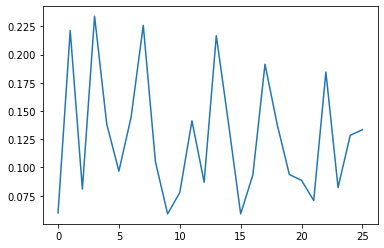

In [52]:
plt.plot(results[0]['accuracies'])

In [ ]:
import pandas as pd
import numpy as np
import json
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier
import joblib
import gc

encoder = LabelEncoder()
encoder.fit(np.unique(y_train))  # Fit encoder to all unique labels in training set

# Define classifiers
classifiers = [
    RandomForestClassifier(n_estimators=75, verbose=2),
    DecisionTreeClassifier(),
    KNeighborsClassifier(),
    LogisticRegression(),
    XGBClassifier(eval_metric='mlogloss', classes=encoder.classes_)
]

batch_size = 100000
results = []

# Train models on batches
for model in classifiers:
    model_name = type(model).__name__
    print(f"Training {model_name}")
    accuracy_list = []

    # Train in batches
    for i in range(0, len(X_train), batch_size):
        batch_end = min(i + batch_size, len(X_train))
        X_batch = X_train[i:batch_end]
        y_batch = y_train[i:batch_end]
        
        try:
            # Fit model on the current batch
            model.fit(X_batch, y_batch)
            # Predict on the entire test set
            y_pred = model.predict(X_test)
            accuracy = accuracy_score(y_test, y_pred)
            accuracy_list.append(accuracy)
            print(f"Batch {i//batch_size + 1}, Accuracy: {accuracy}")
        except Exception as e:
            print(f"Error training {model_name} on batch {i//batch_size + 1}: {e}")
            continue
        
    # Save the model and results
    joblib.dump(model, f'models/{model_name}.joblib')
    results.append({
        'model': model_name,
        'accuracies': accuracy_list
    })
    gc.collect()

# Save results to a JSON file
with open('classification_results.json', 'w') as f:
    json.dump(results, f, indent=4)

print("Training completed and results saved.")

In [54]:
X_train.shape

(15856750, 9)

## Training on raw unbalanced data

In [81]:
from sklearn.model_selection import train_test_split

# Using SMOTE; We have to adjust target column
# Assuming 'data' is your DataFrame and 'target' is the column with class labels; what is the target column for our DataFrame
X = data.iloc[:, 1:]  # Features
y = data.iloc[:, 0]

# Splitting the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

#Crime Classification:
X_train = feature_data_pipeline.fit_transform(X_train)
X_test = feature_data_pipeline.transform(X_test)

In [87]:
import pandas as pd
import numpy as np
import json
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, log_loss
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier
from sklearn.preprocessing import LabelEncoder
import joblib
import gc

# Assuming X_train, y_train, X_test, y_test are defined elsewhere

encoder = LabelEncoder()
encoder.fit(np.unique(y_train))  # Fit encoder to all unique labels in training set

# Define classifiers
classifiers = [
    RandomForestClassifier(n_estimators=75, verbose=2),
    DecisionTreeClassifier(),
    KNeighborsClassifier(),
    LogisticRegression(),
    XGBClassifier(eval_metric='logloss')
]

batch_size = 100000
results = []

# Train models on batches
for model in classifiers:
    model_name = type(model).__name__
    print(f"Training {model_name}")
    accuracy_list = []
    log_loss_list = []

    # Train in batches
    for i in range(0, len(X_train), batch_size):
        batch_end = min(i + batch_size, len(X_train))
        X_batch = X_train[i:batch_end]
        y_batch = y_train[i:batch_end]
        
        try:
            # Fit model on the current batch
            model.fit(X_batch, y_batch)
            
            # Predict on the entire test set
            y_pred = model.predict(X_test)
            y_prob = model.predict_proba(X_test)  # Predict probabilities for log_loss
            
            # Calculate accuracy and log loss
            accuracy = accuracy_score(y_test, y_pred)
            loss = log_loss(y_test, y_prob)  # Calculating log loss
            
            accuracy_list.append(accuracy)
            log_loss_list.append(loss)
            
            print(f"Batch {i//batch_size + 1}, Accuracy: {accuracy}, Log Loss: {loss}")
        except Exception as e:
            print(f"Error training {model_name} on batch {i//batch_size + 1}: {e}")
            continue
        
    # Save the model and results
    joblib.dump(model, f'models/{model_name}_pre_smote.joblib')
    results.append({
        'model': model_name,
        'accuracies': accuracy_list,
        'log_losses': log_loss_list
    })
    gc.collect()

# Save results to a JSON file
with open('classification_results_pre_smote.json', 'w') as f:
    json.dump(results, f, indent=4)

print("Training completed and results saved.")

Training RandomForestClassifier
building tree 1 of 75
building tree 2 of 75
building tree 3 of 75
building tree 4 of 75
building tree 5 of 75
building tree 6 of 75
building tree 7 of 75
building tree 8 of 75
building tree 9 of 75
building tree 10 of 75
building tree 11 of 75
building tree 12 of 75
building tree 13 of 75
building tree 14 of 75
building tree 15 of 75
building tree 16 of 75
building tree 17 of 75
building tree 18 of 75
building tree 19 of 75
building tree 20 of 75
building tree 21 of 75
building tree 22 of 75
building tree 23 of 75
building tree 24 of 75
building tree 25 of 75
building tree 26 of 75
building tree 27 of 75
building tree 28 of 75
building tree 29 of 75
building tree 30 of 75
building tree 31 of 75
building tree 32 of 75
building tree 33 of 75
building tree 34 of 75
building tree 35 of 75
building tree 36 of 75
building tree 37 of 75
building tree 38 of 75
building tree 39 of 75
building tree 40 of 75


[Parallel(n_jobs=1)]: Done  40 tasks      | elapsed:   11.1s


building tree 41 of 75
building tree 42 of 75
building tree 43 of 75
building tree 44 of 75
building tree 45 of 75
building tree 46 of 75
building tree 47 of 75
building tree 48 of 75
building tree 49 of 75
building tree 50 of 75
building tree 51 of 75
building tree 52 of 75
building tree 53 of 75
building tree 54 of 75
building tree 55 of 75
building tree 56 of 75
building tree 57 of 75
building tree 58 of 75
building tree 59 of 75
building tree 60 of 75
building tree 61 of 75
building tree 62 of 75
building tree 63 of 75
building tree 64 of 75
building tree 65 of 75
building tree 66 of 75
building tree 67 of 75
building tree 68 of 75
building tree 69 of 75
building tree 70 of 75
building tree 71 of 75
building tree 72 of 75
building tree 73 of 75
building tree 74 of 75
building tree 75 of 75


[Parallel(n_jobs=1)]: Done  40 tasks      | elapsed:   10.2s
[Parallel(n_jobs=1)]: Done  40 tasks      | elapsed:   10.0s


Batch 1, Accuracy: 0.29337314290732297, Log Loss: 3.7344011506537793
building tree 1 of 75
building tree 2 of 75
building tree 3 of 75
building tree 4 of 75
building tree 5 of 75
building tree 6 of 75
building tree 7 of 75
building tree 8 of 75
building tree 9 of 75
building tree 10 of 75
building tree 11 of 75
building tree 12 of 75
building tree 13 of 75
building tree 14 of 75
building tree 15 of 75
building tree 16 of 75
building tree 17 of 75
building tree 18 of 75
building tree 19 of 75
building tree 20 of 75
building tree 21 of 75
building tree 22 of 75
building tree 23 of 75
building tree 24 of 75
building tree 25 of 75
building tree 26 of 75
building tree 27 of 75
building tree 28 of 75
building tree 29 of 75
building tree 30 of 75
building tree 31 of 75
building tree 32 of 75
building tree 33 of 75
building tree 34 of 75
building tree 35 of 75
building tree 36 of 75
building tree 37 of 75
building tree 38 of 75
building tree 39 of 75
building tree 40 of 75


[Parallel(n_jobs=1)]: Done  40 tasks      | elapsed:   11.2s


building tree 41 of 75
building tree 42 of 75
building tree 43 of 75
building tree 44 of 75
building tree 45 of 75
building tree 46 of 75
building tree 47 of 75
building tree 48 of 75
building tree 49 of 75
building tree 50 of 75
building tree 51 of 75
building tree 52 of 75
building tree 53 of 75
building tree 54 of 75
building tree 55 of 75
building tree 56 of 75
building tree 57 of 75
building tree 58 of 75
building tree 59 of 75
building tree 60 of 75
building tree 61 of 75
building tree 62 of 75
building tree 63 of 75
building tree 64 of 75
building tree 65 of 75
building tree 66 of 75
building tree 67 of 75
building tree 68 of 75
building tree 69 of 75
building tree 70 of 75
building tree 71 of 75
building tree 72 of 75
building tree 73 of 75
building tree 74 of 75
building tree 75 of 75


[Parallel(n_jobs=1)]: Done  40 tasks      | elapsed:   10.0s
[Parallel(n_jobs=1)]: Done  40 tasks      | elapsed:   10.1s


Batch 2, Accuracy: 0.2938633115924096, Log Loss: 3.7279172231893374
building tree 1 of 75
building tree 2 of 75
building tree 3 of 75
building tree 4 of 75
building tree 5 of 75
building tree 6 of 75
building tree 7 of 75
building tree 8 of 75
building tree 9 of 75
building tree 10 of 75
building tree 11 of 75
building tree 12 of 75
building tree 13 of 75
building tree 14 of 75
building tree 15 of 75
building tree 16 of 75
building tree 17 of 75
building tree 18 of 75
building tree 19 of 75
building tree 20 of 75
building tree 21 of 75
building tree 22 of 75
building tree 23 of 75
building tree 24 of 75
building tree 25 of 75
building tree 26 of 75
building tree 27 of 75
building tree 28 of 75
building tree 29 of 75
building tree 30 of 75
building tree 31 of 75
building tree 32 of 75
building tree 33 of 75
building tree 34 of 75
building tree 35 of 75
building tree 36 of 75
building tree 37 of 75
building tree 38 of 75
building tree 39 of 75
building tree 40 of 75


[Parallel(n_jobs=1)]: Done  40 tasks      | elapsed:   11.1s


building tree 41 of 75
building tree 42 of 75
building tree 43 of 75
building tree 44 of 75
building tree 45 of 75
building tree 46 of 75
building tree 47 of 75
building tree 48 of 75
building tree 49 of 75
building tree 50 of 75
building tree 51 of 75
building tree 52 of 75
building tree 53 of 75
building tree 54 of 75
building tree 55 of 75
building tree 56 of 75
building tree 57 of 75
building tree 58 of 75
building tree 59 of 75
building tree 60 of 75
building tree 61 of 75
building tree 62 of 75
building tree 63 of 75
building tree 64 of 75
building tree 65 of 75
building tree 66 of 75
building tree 67 of 75
building tree 68 of 75
building tree 69 of 75
building tree 70 of 75
building tree 71 of 75
building tree 72 of 75
building tree 73 of 75
building tree 74 of 75
building tree 75 of 75


[Parallel(n_jobs=1)]: Done  40 tasks      | elapsed:   10.1s
[Parallel(n_jobs=1)]: Done  40 tasks      | elapsed:   10.1s


Batch 3, Accuracy: 0.29413633714664345, Log Loss: 3.737020742995179
building tree 1 of 75
building tree 2 of 75
building tree 3 of 75
building tree 4 of 75
building tree 5 of 75
building tree 6 of 75
building tree 7 of 75
building tree 8 of 75
building tree 9 of 75
building tree 10 of 75
building tree 11 of 75
building tree 12 of 75
building tree 13 of 75
building tree 14 of 75
building tree 15 of 75
building tree 16 of 75
building tree 17 of 75
building tree 18 of 75
building tree 19 of 75
building tree 20 of 75
building tree 21 of 75
building tree 22 of 75
building tree 23 of 75
building tree 24 of 75
building tree 25 of 75
building tree 26 of 75
building tree 27 of 75
building tree 28 of 75
building tree 29 of 75
building tree 30 of 75
building tree 31 of 75
building tree 32 of 75
building tree 33 of 75
building tree 34 of 75
building tree 35 of 75
building tree 36 of 75
building tree 37 of 75
building tree 38 of 75
building tree 39 of 75
building tree 40 of 75


[Parallel(n_jobs=1)]: Done  40 tasks      | elapsed:   11.3s


building tree 41 of 75
building tree 42 of 75
building tree 43 of 75
building tree 44 of 75
building tree 45 of 75
building tree 46 of 75
building tree 47 of 75
building tree 48 of 75
building tree 49 of 75
building tree 50 of 75
building tree 51 of 75
building tree 52 of 75
building tree 53 of 75
building tree 54 of 75
building tree 55 of 75
building tree 56 of 75
building tree 57 of 75
building tree 58 of 75
building tree 59 of 75
building tree 60 of 75
building tree 61 of 75
building tree 62 of 75
building tree 63 of 75
building tree 64 of 75
building tree 65 of 75
building tree 66 of 75
building tree 67 of 75
building tree 68 of 75
building tree 69 of 75
building tree 70 of 75
building tree 71 of 75
building tree 72 of 75
building tree 73 of 75
building tree 74 of 75
building tree 75 of 75


[Parallel(n_jobs=1)]: Done  40 tasks      | elapsed:   10.3s
[Parallel(n_jobs=1)]: Done  40 tasks      | elapsed:   10.6s


Batch 4, Accuracy: 0.2934849077540854, Log Loss: 3.7353631664972236
building tree 1 of 75
building tree 2 of 75
building tree 3 of 75
building tree 4 of 75
building tree 5 of 75
building tree 6 of 75
building tree 7 of 75
building tree 8 of 75
building tree 9 of 75
building tree 10 of 75
building tree 11 of 75
building tree 12 of 75
building tree 13 of 75
building tree 14 of 75
building tree 15 of 75
building tree 16 of 75
building tree 17 of 75
building tree 18 of 75
building tree 19 of 75
building tree 20 of 75
building tree 21 of 75
building tree 22 of 75
building tree 23 of 75
building tree 24 of 75
building tree 25 of 75
building tree 26 of 75
building tree 27 of 75
building tree 28 of 75
building tree 29 of 75
building tree 30 of 75
building tree 31 of 75
building tree 32 of 75
building tree 33 of 75
building tree 34 of 75
building tree 35 of 75
building tree 36 of 75
building tree 37 of 75
building tree 38 of 75
building tree 39 of 75
building tree 40 of 75


[Parallel(n_jobs=1)]: Done  40 tasks      | elapsed:   11.3s


building tree 41 of 75
building tree 42 of 75
building tree 43 of 75
building tree 44 of 75
building tree 45 of 75
building tree 46 of 75
building tree 47 of 75
building tree 48 of 75
building tree 49 of 75
building tree 50 of 75
building tree 51 of 75
building tree 52 of 75
building tree 53 of 75
building tree 54 of 75
building tree 55 of 75
building tree 56 of 75
building tree 57 of 75
building tree 58 of 75
building tree 59 of 75
building tree 60 of 75
building tree 61 of 75
building tree 62 of 75
building tree 63 of 75
building tree 64 of 75
building tree 65 of 75
building tree 66 of 75
building tree 67 of 75
building tree 68 of 75
building tree 69 of 75
building tree 70 of 75
building tree 71 of 75
building tree 72 of 75
building tree 73 of 75
building tree 74 of 75
building tree 75 of 75


[Parallel(n_jobs=1)]: Done  40 tasks      | elapsed:   10.1s
[Parallel(n_jobs=1)]: Done  40 tasks      | elapsed:   10.2s


Batch 5, Accuracy: 0.2943151609014633, Log Loss: 3.7576091493820107
building tree 1 of 75
building tree 2 of 75
building tree 3 of 75
building tree 4 of 75
building tree 5 of 75
building tree 6 of 75
building tree 7 of 75
building tree 8 of 75
building tree 9 of 75
building tree 10 of 75
building tree 11 of 75
building tree 12 of 75
building tree 13 of 75
building tree 14 of 75
building tree 15 of 75
building tree 16 of 75
building tree 17 of 75
building tree 18 of 75
building tree 19 of 75
building tree 20 of 75
building tree 21 of 75
building tree 22 of 75
building tree 23 of 75
building tree 24 of 75
building tree 25 of 75
building tree 26 of 75
building tree 27 of 75
building tree 28 of 75
building tree 29 of 75
building tree 30 of 75
building tree 31 of 75
building tree 32 of 75
building tree 33 of 75
building tree 34 of 75
building tree 35 of 75
building tree 36 of 75
building tree 37 of 75
building tree 38 of 75
building tree 39 of 75
building tree 40 of 75


[Parallel(n_jobs=1)]: Done  40 tasks      | elapsed:   11.0s


building tree 41 of 75
building tree 42 of 75
building tree 43 of 75
building tree 44 of 75
building tree 45 of 75
building tree 46 of 75
building tree 47 of 75
building tree 48 of 75
building tree 49 of 75
building tree 50 of 75
building tree 51 of 75
building tree 52 of 75
building tree 53 of 75
building tree 54 of 75
building tree 55 of 75
building tree 56 of 75
building tree 57 of 75
building tree 58 of 75
building tree 59 of 75
building tree 60 of 75
building tree 61 of 75
building tree 62 of 75
building tree 63 of 75
building tree 64 of 75
building tree 65 of 75
building tree 66 of 75
building tree 67 of 75
building tree 68 of 75
building tree 69 of 75
building tree 70 of 75
building tree 71 of 75
building tree 72 of 75
building tree 73 of 75
building tree 74 of 75
building tree 75 of 75


[Parallel(n_jobs=1)]: Done  40 tasks      | elapsed:   10.0s
[Parallel(n_jobs=1)]: Done  40 tasks      | elapsed:   10.1s


Batch 6, Accuracy: 0.29368129455625364, Log Loss: 3.743825081518765
building tree 1 of 75
building tree 2 of 75
building tree 3 of 75
building tree 4 of 75
building tree 5 of 75
building tree 6 of 75
building tree 7 of 75
building tree 8 of 75
building tree 9 of 75
building tree 10 of 75
building tree 11 of 75
building tree 12 of 75
building tree 13 of 75
building tree 14 of 75
building tree 15 of 75
building tree 16 of 75
building tree 17 of 75
building tree 18 of 75
building tree 19 of 75
building tree 20 of 75
building tree 21 of 75
building tree 22 of 75
building tree 23 of 75
building tree 24 of 75
building tree 25 of 75
building tree 26 of 75
building tree 27 of 75
building tree 28 of 75
building tree 29 of 75
building tree 30 of 75
building tree 31 of 75
building tree 32 of 75
building tree 33 of 75
building tree 34 of 75
building tree 35 of 75
building tree 36 of 75
building tree 37 of 75
building tree 38 of 75
building tree 39 of 75
building tree 40 of 75


[Parallel(n_jobs=1)]: Done  40 tasks      | elapsed:   11.0s


building tree 41 of 75
building tree 42 of 75
building tree 43 of 75
building tree 44 of 75
building tree 45 of 75
building tree 46 of 75
building tree 47 of 75
building tree 48 of 75
building tree 49 of 75
building tree 50 of 75
building tree 51 of 75
building tree 52 of 75
building tree 53 of 75
building tree 54 of 75
building tree 55 of 75
building tree 56 of 75
building tree 57 of 75
building tree 58 of 75
building tree 59 of 75
building tree 60 of 75
building tree 61 of 75
building tree 62 of 75
building tree 63 of 75
building tree 64 of 75
building tree 65 of 75
building tree 66 of 75
building tree 67 of 75
building tree 68 of 75
building tree 69 of 75
building tree 70 of 75
building tree 71 of 75
building tree 72 of 75
building tree 73 of 75
building tree 74 of 75
building tree 75 of 75


[Parallel(n_jobs=1)]: Done  40 tasks      | elapsed:   10.1s
[Parallel(n_jobs=1)]: Done  40 tasks      | elapsed:   10.0s


Batch 7, Accuracy: 0.29294524320828974, Log Loss: 3.7536736824537993
building tree 1 of 75
building tree 2 of 75
building tree 3 of 75
building tree 4 of 75
building tree 5 of 75
building tree 6 of 75
building tree 7 of 75
building tree 8 of 75
building tree 9 of 75
building tree 10 of 75
building tree 11 of 75
building tree 12 of 75
building tree 13 of 75
building tree 14 of 75
building tree 15 of 75
building tree 16 of 75
building tree 17 of 75
building tree 18 of 75
building tree 19 of 75
building tree 20 of 75
building tree 21 of 75
building tree 22 of 75
building tree 23 of 75
building tree 24 of 75
building tree 25 of 75
building tree 26 of 75
building tree 27 of 75
building tree 28 of 75
building tree 29 of 75
building tree 30 of 75
building tree 31 of 75
building tree 32 of 75
building tree 33 of 75
building tree 34 of 75
building tree 35 of 75
building tree 36 of 75
building tree 37 of 75
building tree 38 of 75
building tree 39 of 75
building tree 40 of 75


[Parallel(n_jobs=1)]: Done  40 tasks      | elapsed:   11.1s


building tree 41 of 75
building tree 42 of 75
building tree 43 of 75
building tree 44 of 75
building tree 45 of 75
building tree 46 of 75
building tree 47 of 75
building tree 48 of 75
building tree 49 of 75
building tree 50 of 75
building tree 51 of 75
building tree 52 of 75
building tree 53 of 75
building tree 54 of 75
building tree 55 of 75
building tree 56 of 75
building tree 57 of 75
building tree 58 of 75
building tree 59 of 75
building tree 60 of 75
building tree 61 of 75
building tree 62 of 75
building tree 63 of 75
building tree 64 of 75
building tree 65 of 75
building tree 66 of 75
building tree 67 of 75
building tree 68 of 75
building tree 69 of 75
building tree 70 of 75
building tree 71 of 75
building tree 72 of 75
building tree 73 of 75
building tree 74 of 75
building tree 75 of 75


[Parallel(n_jobs=1)]: Done  40 tasks      | elapsed:   10.0s
[Parallel(n_jobs=1)]: Done  40 tasks      | elapsed:   10.0s


Batch 8, Accuracy: 0.29326297470122864, Log Loss: 3.746543331945398
building tree 1 of 75
building tree 2 of 75
building tree 3 of 75
building tree 4 of 75
building tree 5 of 75
building tree 6 of 75
building tree 7 of 75
building tree 8 of 75
building tree 9 of 75
building tree 10 of 75
building tree 11 of 75
building tree 12 of 75
building tree 13 of 75
building tree 14 of 75
building tree 15 of 75
building tree 16 of 75
building tree 17 of 75
building tree 18 of 75
building tree 19 of 75
building tree 20 of 75
building tree 21 of 75
building tree 22 of 75
building tree 23 of 75
building tree 24 of 75
building tree 25 of 75
building tree 26 of 75
building tree 27 of 75
building tree 28 of 75
building tree 29 of 75
building tree 30 of 75
building tree 31 of 75
building tree 32 of 75
building tree 33 of 75
building tree 34 of 75
building tree 35 of 75
building tree 36 of 75
building tree 37 of 75
building tree 38 of 75
building tree 39 of 75
building tree 40 of 75


[Parallel(n_jobs=1)]: Done  40 tasks      | elapsed:   11.1s


building tree 41 of 75
building tree 42 of 75
building tree 43 of 75
building tree 44 of 75
building tree 45 of 75
building tree 46 of 75
building tree 47 of 75
building tree 48 of 75
building tree 49 of 75
building tree 50 of 75
building tree 51 of 75
building tree 52 of 75
building tree 53 of 75
building tree 54 of 75
building tree 55 of 75
building tree 56 of 75
building tree 57 of 75
building tree 58 of 75
building tree 59 of 75
building tree 60 of 75
building tree 61 of 75
building tree 62 of 75
building tree 63 of 75
building tree 64 of 75
building tree 65 of 75
building tree 66 of 75
building tree 67 of 75
building tree 68 of 75
building tree 69 of 75
building tree 70 of 75
building tree 71 of 75
building tree 72 of 75
building tree 73 of 75
building tree 74 of 75
building tree 75 of 75


[Parallel(n_jobs=1)]: Done  40 tasks      | elapsed:   12.5s
[Parallel(n_jobs=1)]: Done  40 tasks      | elapsed:   10.4s


Batch 9, Accuracy: 0.29391280745311865, Log Loss: 3.7497156402976812
building tree 1 of 75
building tree 2 of 75
building tree 3 of 75
building tree 4 of 75
building tree 5 of 75
building tree 6 of 75
building tree 7 of 75
building tree 8 of 75
building tree 9 of 75
building tree 10 of 75
building tree 11 of 75
building tree 12 of 75
building tree 13 of 75
building tree 14 of 75
building tree 15 of 75
building tree 16 of 75
building tree 17 of 75
building tree 18 of 75
building tree 19 of 75
building tree 20 of 75
building tree 21 of 75
building tree 22 of 75
building tree 23 of 75
building tree 24 of 75
building tree 25 of 75
building tree 26 of 75
building tree 27 of 75
building tree 28 of 75
building tree 29 of 75
building tree 30 of 75
building tree 31 of 75
building tree 32 of 75
building tree 33 of 75
building tree 34 of 75
building tree 35 of 75
building tree 36 of 75
building tree 37 of 75
building tree 38 of 75
building tree 39 of 75
building tree 40 of 75


[Parallel(n_jobs=1)]: Done  40 tasks      | elapsed:   11.0s


building tree 41 of 75
building tree 42 of 75
building tree 43 of 75
building tree 44 of 75
building tree 45 of 75
building tree 46 of 75
building tree 47 of 75
building tree 48 of 75
building tree 49 of 75
building tree 50 of 75
building tree 51 of 75
building tree 52 of 75
building tree 53 of 75
building tree 54 of 75
building tree 55 of 75
building tree 56 of 75
building tree 57 of 75
building tree 58 of 75
building tree 59 of 75
building tree 60 of 75
building tree 61 of 75
building tree 62 of 75
building tree 63 of 75
building tree 64 of 75
building tree 65 of 75
building tree 66 of 75
building tree 67 of 75
building tree 68 of 75
building tree 69 of 75
building tree 70 of 75
building tree 71 of 75
building tree 72 of 75
building tree 73 of 75
building tree 74 of 75
building tree 75 of 75


[Parallel(n_jobs=1)]: Done  40 tasks      | elapsed:   10.6s
[Parallel(n_jobs=1)]: Done  40 tasks      | elapsed:   10.8s


Batch 10, Accuracy: 0.2925955789019902, Log Loss: 3.7422689552363333
building tree 1 of 75
building tree 2 of 75
building tree 3 of 75
building tree 4 of 75
building tree 5 of 75
building tree 6 of 75
building tree 7 of 75
building tree 8 of 75
building tree 9 of 75
building tree 10 of 75
building tree 11 of 75
building tree 12 of 75
building tree 13 of 75
building tree 14 of 75
building tree 15 of 75
building tree 16 of 75
building tree 17 of 75
building tree 18 of 75
building tree 19 of 75
building tree 20 of 75
building tree 21 of 75
building tree 22 of 75
building tree 23 of 75
building tree 24 of 75
building tree 25 of 75
building tree 26 of 75
building tree 27 of 75
building tree 28 of 75
building tree 29 of 75
building tree 30 of 75
building tree 31 of 75
building tree 32 of 75
building tree 33 of 75
building tree 34 of 75
building tree 35 of 75
building tree 36 of 75
building tree 37 of 75
building tree 38 of 75
building tree 39 of 75
building tree 40 of 75


[Parallel(n_jobs=1)]: Done  40 tasks      | elapsed:   12.3s


building tree 41 of 75
building tree 42 of 75
building tree 43 of 75
building tree 44 of 75
building tree 45 of 75
building tree 46 of 75
building tree 47 of 75
building tree 48 of 75
building tree 49 of 75
building tree 50 of 75
building tree 51 of 75
building tree 52 of 75
building tree 53 of 75
building tree 54 of 75
building tree 55 of 75
building tree 56 of 75
building tree 57 of 75
building tree 58 of 75
building tree 59 of 75
building tree 60 of 75
building tree 61 of 75
building tree 62 of 75
building tree 63 of 75
building tree 64 of 75
building tree 65 of 75
building tree 66 of 75
building tree 67 of 75
building tree 68 of 75
building tree 69 of 75
building tree 70 of 75
building tree 71 of 75
building tree 72 of 75
building tree 73 of 75
building tree 74 of 75
building tree 75 of 75


[Parallel(n_jobs=1)]: Done  40 tasks      | elapsed:   10.6s
[Parallel(n_jobs=1)]: Done  40 tasks      | elapsed:   10.7s


Batch 11, Accuracy: 0.29374356354230696, Log Loss: 3.74839770270058
building tree 1 of 75
building tree 2 of 75
building tree 3 of 75
building tree 4 of 75
building tree 5 of 75
building tree 6 of 75
building tree 7 of 75
building tree 8 of 75
building tree 9 of 75
building tree 10 of 75
building tree 11 of 75
building tree 12 of 75
building tree 13 of 75
building tree 14 of 75
building tree 15 of 75
building tree 16 of 75
building tree 17 of 75
building tree 18 of 75
building tree 19 of 75
building tree 20 of 75
building tree 21 of 75
building tree 22 of 75
building tree 23 of 75
building tree 24 of 75
building tree 25 of 75
building tree 26 of 75
building tree 27 of 75
building tree 28 of 75
building tree 29 of 75
building tree 30 of 75
building tree 31 of 75
building tree 32 of 75
building tree 33 of 75
building tree 34 of 75
building tree 35 of 75
building tree 36 of 75
building tree 37 of 75
building tree 38 of 75
building tree 39 of 75
building tree 40 of 75


[Parallel(n_jobs=1)]: Done  40 tasks      | elapsed:   11.5s


building tree 41 of 75
building tree 42 of 75
building tree 43 of 75
building tree 44 of 75
building tree 45 of 75
building tree 46 of 75
building tree 47 of 75
building tree 48 of 75
building tree 49 of 75
building tree 50 of 75
building tree 51 of 75
building tree 52 of 75
building tree 53 of 75
building tree 54 of 75
building tree 55 of 75
building tree 56 of 75
building tree 57 of 75
building tree 58 of 75
building tree 59 of 75
building tree 60 of 75
building tree 61 of 75
building tree 62 of 75
building tree 63 of 75
building tree 64 of 75
building tree 65 of 75
building tree 66 of 75
building tree 67 of 75
building tree 68 of 75
building tree 69 of 75
building tree 70 of 75
building tree 71 of 75
building tree 72 of 75
building tree 73 of 75
building tree 74 of 75
building tree 75 of 75


[Parallel(n_jobs=1)]: Done  40 tasks      | elapsed:   10.1s
[Parallel(n_jobs=1)]: Done  40 tasks      | elapsed:   10.5s


Batch 12, Accuracy: 0.29323742845054007, Log Loss: 3.7471847382907804
building tree 1 of 75
building tree 2 of 75
building tree 3 of 75
building tree 4 of 75
building tree 5 of 75
building tree 6 of 75
building tree 7 of 75
building tree 8 of 75
building tree 9 of 75
building tree 10 of 75
building tree 11 of 75
building tree 12 of 75
building tree 13 of 75
building tree 14 of 75
building tree 15 of 75
building tree 16 of 75
building tree 17 of 75
building tree 18 of 75
building tree 19 of 75
building tree 20 of 75
building tree 21 of 75
building tree 22 of 75
building tree 23 of 75
building tree 24 of 75
building tree 25 of 75
building tree 26 of 75
building tree 27 of 75
building tree 28 of 75
building tree 29 of 75
building tree 30 of 75
building tree 31 of 75
building tree 32 of 75
building tree 33 of 75
building tree 34 of 75
building tree 35 of 75
building tree 36 of 75
building tree 37 of 75
building tree 38 of 75
building tree 39 of 75
building tree 40 of 75


[Parallel(n_jobs=1)]: Done  40 tasks      | elapsed:   11.3s


building tree 41 of 75
building tree 42 of 75
building tree 43 of 75
building tree 44 of 75
building tree 45 of 75
building tree 46 of 75
building tree 47 of 75
building tree 48 of 75
building tree 49 of 75
building tree 50 of 75
building tree 51 of 75
building tree 52 of 75
building tree 53 of 75
building tree 54 of 75
building tree 55 of 75
building tree 56 of 75
building tree 57 of 75
building tree 58 of 75
building tree 59 of 75
building tree 60 of 75
building tree 61 of 75
building tree 62 of 75
building tree 63 of 75
building tree 64 of 75
building tree 65 of 75
building tree 66 of 75
building tree 67 of 75
building tree 68 of 75
building tree 69 of 75
building tree 70 of 75
building tree 71 of 75
building tree 72 of 75
building tree 73 of 75
building tree 74 of 75
building tree 75 of 75


[Parallel(n_jobs=1)]: Done  40 tasks      | elapsed:   10.5s
[Parallel(n_jobs=1)]: Done  40 tasks      | elapsed:   10.7s


Batch 13, Accuracy: 0.29328213438924505, Log Loss: 3.7197453787134775
building tree 1 of 75
building tree 2 of 75
building tree 3 of 75
building tree 4 of 75
building tree 5 of 75
building tree 6 of 75
building tree 7 of 75
building tree 8 of 75
building tree 9 of 75
building tree 10 of 75
building tree 11 of 75
building tree 12 of 75
building tree 13 of 75
building tree 14 of 75
building tree 15 of 75
building tree 16 of 75
building tree 17 of 75
building tree 18 of 75
building tree 19 of 75
building tree 20 of 75
building tree 21 of 75
building tree 22 of 75
building tree 23 of 75
building tree 24 of 75
building tree 25 of 75
building tree 26 of 75
building tree 27 of 75
building tree 28 of 75
building tree 29 of 75
building tree 30 of 75
building tree 31 of 75
building tree 32 of 75
building tree 33 of 75
building tree 34 of 75
building tree 35 of 75
building tree 36 of 75
building tree 37 of 75
building tree 38 of 75
building tree 39 of 75
building tree 40 of 75


[Parallel(n_jobs=1)]: Done  40 tasks      | elapsed:   13.9s


building tree 41 of 75
building tree 42 of 75
building tree 43 of 75
building tree 44 of 75
building tree 45 of 75
building tree 46 of 75
building tree 47 of 75
building tree 48 of 75
building tree 49 of 75
building tree 50 of 75
building tree 51 of 75
building tree 52 of 75
building tree 53 of 75
building tree 54 of 75
building tree 55 of 75
building tree 56 of 75
building tree 57 of 75
building tree 58 of 75
building tree 59 of 75
building tree 60 of 75
building tree 61 of 75
building tree 62 of 75
building tree 63 of 75
building tree 64 of 75
building tree 65 of 75
building tree 66 of 75
building tree 67 of 75
building tree 68 of 75
building tree 69 of 75
building tree 70 of 75
building tree 71 of 75
building tree 72 of 75
building tree 73 of 75
building tree 74 of 75
building tree 75 of 75


[Parallel(n_jobs=1)]: Done  40 tasks      | elapsed:   12.0s
[Parallel(n_jobs=1)]: Done  40 tasks      | elapsed:   11.1s


Batch 14, Accuracy: 0.2940628916759139, Log Loss: 3.7457238969582636
building tree 1 of 75
building tree 2 of 75
building tree 3 of 75
building tree 4 of 75
building tree 5 of 75
building tree 6 of 75
building tree 7 of 75
building tree 8 of 75
building tree 9 of 75
building tree 10 of 75
building tree 11 of 75
building tree 12 of 75
building tree 13 of 75
building tree 14 of 75
building tree 15 of 75
building tree 16 of 75
building tree 17 of 75
building tree 18 of 75
building tree 19 of 75
building tree 20 of 75
building tree 21 of 75
building tree 22 of 75
building tree 23 of 75
building tree 24 of 75
building tree 25 of 75
building tree 26 of 75
building tree 27 of 75
building tree 28 of 75
building tree 29 of 75
building tree 30 of 75
building tree 31 of 75
building tree 32 of 75
building tree 33 of 75
building tree 34 of 75
building tree 35 of 75
building tree 36 of 75
building tree 37 of 75
building tree 38 of 75
building tree 39 of 75
building tree 40 of 75


[Parallel(n_jobs=1)]: Done  40 tasks      | elapsed:   11.0s


building tree 41 of 75
building tree 42 of 75
building tree 43 of 75
building tree 44 of 75
building tree 45 of 75
building tree 46 of 75
building tree 47 of 75
building tree 48 of 75
building tree 49 of 75
building tree 50 of 75
building tree 51 of 75
building tree 52 of 75
building tree 53 of 75
building tree 54 of 75
building tree 55 of 75
building tree 56 of 75
building tree 57 of 75
building tree 58 of 75
building tree 59 of 75
building tree 60 of 75
building tree 61 of 75
building tree 62 of 75
building tree 63 of 75
building tree 64 of 75
building tree 65 of 75
building tree 66 of 75
building tree 67 of 75
building tree 68 of 75
building tree 69 of 75
building tree 70 of 75
building tree 71 of 75
building tree 72 of 75
building tree 73 of 75
building tree 74 of 75
building tree 75 of 75


[Parallel(n_jobs=1)]: Done  40 tasks      | elapsed:   10.1s
[Parallel(n_jobs=1)]: Done  40 tasks      | elapsed:   10.3s


Batch 15, Accuracy: 0.2932390250912081, Log Loss: 3.7534592531671396
building tree 1 of 75
building tree 2 of 75
building tree 3 of 75
building tree 4 of 75
building tree 5 of 75
building tree 6 of 75
building tree 7 of 75
building tree 8 of 75
building tree 9 of 75
building tree 10 of 75
building tree 11 of 75
building tree 12 of 75
building tree 13 of 75
building tree 14 of 75
building tree 15 of 75
building tree 16 of 75
building tree 17 of 75
building tree 18 of 75
building tree 19 of 75
building tree 20 of 75
building tree 21 of 75
building tree 22 of 75
building tree 23 of 75
building tree 24 of 75
building tree 25 of 75
building tree 26 of 75
building tree 27 of 75
building tree 28 of 75
building tree 29 of 75
building tree 30 of 75
building tree 31 of 75
building tree 32 of 75
building tree 33 of 75
building tree 34 of 75
building tree 35 of 75
building tree 36 of 75
building tree 37 of 75
building tree 38 of 75
building tree 39 of 75
building tree 40 of 75


[Parallel(n_jobs=1)]: Done  40 tasks      | elapsed:   11.1s


building tree 41 of 75
building tree 42 of 75
building tree 43 of 75
building tree 44 of 75
building tree 45 of 75
building tree 46 of 75
building tree 47 of 75
building tree 48 of 75
building tree 49 of 75
building tree 50 of 75
building tree 51 of 75
building tree 52 of 75
building tree 53 of 75
building tree 54 of 75
building tree 55 of 75
building tree 56 of 75
building tree 57 of 75
building tree 58 of 75
building tree 59 of 75
building tree 60 of 75
building tree 61 of 75
building tree 62 of 75
building tree 63 of 75
building tree 64 of 75
building tree 65 of 75
building tree 66 of 75
building tree 67 of 75
building tree 68 of 75
building tree 69 of 75
building tree 70 of 75
building tree 71 of 75
building tree 72 of 75
building tree 73 of 75
building tree 74 of 75
building tree 75 of 75


[Parallel(n_jobs=1)]: Done  40 tasks      | elapsed:   10.1s
[Parallel(n_jobs=1)]: Done  40 tasks      | elapsed:   10.1s


Batch 16, Accuracy: 0.2947127244278039, Log Loss: 3.7254280603425975
building tree 1 of 75
building tree 2 of 75
building tree 3 of 75
building tree 4 of 75
building tree 5 of 75
building tree 6 of 75
building tree 7 of 75
building tree 8 of 75
building tree 9 of 75
building tree 10 of 75
building tree 11 of 75
building tree 12 of 75
building tree 13 of 75
building tree 14 of 75
building tree 15 of 75
building tree 16 of 75
building tree 17 of 75
building tree 18 of 75
building tree 19 of 75
building tree 20 of 75
building tree 21 of 75
building tree 22 of 75
building tree 23 of 75
building tree 24 of 75
building tree 25 of 75
building tree 26 of 75
building tree 27 of 75
building tree 28 of 75
building tree 29 of 75
building tree 30 of 75
building tree 31 of 75
building tree 32 of 75
building tree 33 of 75
building tree 34 of 75
building tree 35 of 75
building tree 36 of 75
building tree 37 of 75
building tree 38 of 75
building tree 39 of 75
building tree 40 of 75


[Parallel(n_jobs=1)]: Done  40 tasks      | elapsed:   11.2s


building tree 41 of 75
building tree 42 of 75
building tree 43 of 75
building tree 44 of 75
building tree 45 of 75
building tree 46 of 75
building tree 47 of 75
building tree 48 of 75
building tree 49 of 75
building tree 50 of 75
building tree 51 of 75
building tree 52 of 75
building tree 53 of 75
building tree 54 of 75
building tree 55 of 75
building tree 56 of 75
building tree 57 of 75
building tree 58 of 75
building tree 59 of 75
building tree 60 of 75
building tree 61 of 75
building tree 62 of 75
building tree 63 of 75
building tree 64 of 75
building tree 65 of 75
building tree 66 of 75
building tree 67 of 75
building tree 68 of 75
building tree 69 of 75
building tree 70 of 75
building tree 71 of 75
building tree 72 of 75
building tree 73 of 75
building tree 74 of 75
building tree 75 of 75


[Parallel(n_jobs=1)]: Done  40 tasks      | elapsed:   10.1s
[Parallel(n_jobs=1)]: Done  40 tasks      | elapsed:   10.1s


Batch 17, Accuracy: 0.293927177219131, Log Loss: 3.736511353485436
building tree 1 of 75
building tree 2 of 75
building tree 3 of 75
building tree 4 of 75
building tree 5 of 75
building tree 6 of 75
building tree 7 of 75
building tree 8 of 75
building tree 9 of 75
building tree 10 of 75
building tree 11 of 75
building tree 12 of 75
building tree 13 of 75
building tree 14 of 75
building tree 15 of 75
building tree 16 of 75
building tree 17 of 75
building tree 18 of 75
building tree 19 of 75
building tree 20 of 75
building tree 21 of 75
building tree 22 of 75
building tree 23 of 75
building tree 24 of 75
building tree 25 of 75
building tree 26 of 75
building tree 27 of 75
building tree 28 of 75
building tree 29 of 75
building tree 30 of 75
building tree 31 of 75
building tree 32 of 75
building tree 33 of 75
building tree 34 of 75
building tree 35 of 75
building tree 36 of 75
building tree 37 of 75
building tree 38 of 75
building tree 39 of 75
building tree 40 of 75


[Parallel(n_jobs=1)]: Done  40 tasks      | elapsed:   11.1s


building tree 41 of 75
building tree 42 of 75
building tree 43 of 75
building tree 44 of 75
building tree 45 of 75
building tree 46 of 75
building tree 47 of 75
building tree 48 of 75
building tree 49 of 75
building tree 50 of 75
building tree 51 of 75
building tree 52 of 75
building tree 53 of 75
building tree 54 of 75
building tree 55 of 75
building tree 56 of 75
building tree 57 of 75
building tree 58 of 75
building tree 59 of 75
building tree 60 of 75
building tree 61 of 75
building tree 62 of 75
building tree 63 of 75
building tree 64 of 75
building tree 65 of 75
building tree 66 of 75
building tree 67 of 75
building tree 68 of 75
building tree 69 of 75
building tree 70 of 75
building tree 71 of 75
building tree 72 of 75
building tree 73 of 75
building tree 74 of 75
building tree 75 of 75


[Parallel(n_jobs=1)]: Done  40 tasks      | elapsed:   10.5s
[Parallel(n_jobs=1)]: Done  40 tasks      | elapsed:   10.3s


Batch 18, Accuracy: 0.29493625412132873, Log Loss: 3.736140321724271
building tree 1 of 75
building tree 2 of 75
building tree 3 of 75
building tree 4 of 75
building tree 5 of 75
building tree 6 of 75
building tree 7 of 75
building tree 8 of 75
building tree 9 of 75
building tree 10 of 75
building tree 11 of 75
building tree 12 of 75
building tree 13 of 75
building tree 14 of 75
building tree 15 of 75
building tree 16 of 75
building tree 17 of 75
building tree 18 of 75
building tree 19 of 75
building tree 20 of 75
building tree 21 of 75
building tree 22 of 75
building tree 23 of 75
building tree 24 of 75
building tree 25 of 75
building tree 26 of 75
building tree 27 of 75
building tree 28 of 75
building tree 29 of 75
building tree 30 of 75
building tree 31 of 75
building tree 32 of 75
building tree 33 of 75
building tree 34 of 75
building tree 35 of 75
building tree 36 of 75
building tree 37 of 75
building tree 38 of 75
building tree 39 of 75
building tree 40 of 75


[Parallel(n_jobs=1)]: Done  40 tasks      | elapsed:   11.0s


building tree 41 of 75
building tree 42 of 75
building tree 43 of 75
building tree 44 of 75
building tree 45 of 75
building tree 46 of 75
building tree 47 of 75
building tree 48 of 75
building tree 49 of 75
building tree 50 of 75
building tree 51 of 75
building tree 52 of 75
building tree 53 of 75
building tree 54 of 75
building tree 55 of 75
building tree 56 of 75
building tree 57 of 75
building tree 58 of 75
building tree 59 of 75
building tree 60 of 75
building tree 61 of 75
building tree 62 of 75
building tree 63 of 75
building tree 64 of 75
building tree 65 of 75
building tree 66 of 75
building tree 67 of 75
building tree 68 of 75
building tree 69 of 75
building tree 70 of 75
building tree 71 of 75
building tree 72 of 75
building tree 73 of 75
building tree 74 of 75
building tree 75 of 75


[Parallel(n_jobs=1)]: Done  40 tasks      | elapsed:   10.1s
[Parallel(n_jobs=1)]: Done  40 tasks      | elapsed:   10.1s


Batch 19, Accuracy: 0.2932965041552573, Log Loss: 3.745277939295202
building tree 1 of 75
building tree 2 of 75
building tree 3 of 75
building tree 4 of 75
building tree 5 of 75
building tree 6 of 75
building tree 7 of 75
building tree 8 of 75
building tree 9 of 75
building tree 10 of 75
building tree 11 of 75
building tree 12 of 75
building tree 13 of 75
building tree 14 of 75
building tree 15 of 75
building tree 16 of 75
building tree 17 of 75
building tree 18 of 75
building tree 19 of 75
building tree 20 of 75
building tree 21 of 75
building tree 22 of 75
building tree 23 of 75
building tree 24 of 75
building tree 25 of 75
building tree 26 of 75
building tree 27 of 75
building tree 28 of 75
building tree 29 of 75
building tree 30 of 75
building tree 31 of 75
building tree 32 of 75
building tree 33 of 75
building tree 34 of 75
building tree 35 of 75
building tree 36 of 75
building tree 37 of 75
building tree 38 of 75
building tree 39 of 75
building tree 40 of 75


[Parallel(n_jobs=1)]: Done  40 tasks      | elapsed:   11.1s


building tree 41 of 75
building tree 42 of 75
building tree 43 of 75
building tree 44 of 75
building tree 45 of 75
building tree 46 of 75
building tree 47 of 75
building tree 48 of 75
building tree 49 of 75
building tree 50 of 75
building tree 51 of 75
building tree 52 of 75
building tree 53 of 75
building tree 54 of 75
building tree 55 of 75
building tree 56 of 75
building tree 57 of 75
building tree 58 of 75
building tree 59 of 75
building tree 60 of 75
building tree 61 of 75
building tree 62 of 75
building tree 63 of 75
building tree 64 of 75
building tree 65 of 75
building tree 66 of 75
building tree 67 of 75
building tree 68 of 75
building tree 69 of 75
building tree 70 of 75
building tree 71 of 75
building tree 72 of 75
building tree 73 of 75
building tree 74 of 75
building tree 75 of 75


[Parallel(n_jobs=1)]: Done  40 tasks      | elapsed:   11.6s
[Parallel(n_jobs=1)]: Done  40 tasks      | elapsed:   11.8s


Batch 20, Accuracy: 0.2937818829183398, Log Loss: 3.747506444181314
building tree 1 of 75
building tree 2 of 75
building tree 3 of 75
building tree 4 of 75
building tree 5 of 75
building tree 6 of 75
building tree 7 of 75
building tree 8 of 75
building tree 9 of 75
building tree 10 of 75
building tree 11 of 75
building tree 12 of 75
building tree 13 of 75
building tree 14 of 75
building tree 15 of 75
building tree 16 of 75
building tree 17 of 75
building tree 18 of 75
building tree 19 of 75
building tree 20 of 75
building tree 21 of 75
building tree 22 of 75
building tree 23 of 75
building tree 24 of 75
building tree 25 of 75
building tree 26 of 75
building tree 27 of 75
building tree 28 of 75
building tree 29 of 75
building tree 30 of 75
building tree 31 of 75
building tree 32 of 75
building tree 33 of 75
building tree 34 of 75
building tree 35 of 75
building tree 36 of 75
building tree 37 of 75
building tree 38 of 75
building tree 39 of 75
building tree 40 of 75


[Parallel(n_jobs=1)]: Done  40 tasks      | elapsed:   11.3s


building tree 41 of 75
building tree 42 of 75
building tree 43 of 75
building tree 44 of 75
building tree 45 of 75
building tree 46 of 75
building tree 47 of 75
building tree 48 of 75
building tree 49 of 75
building tree 50 of 75
building tree 51 of 75
building tree 52 of 75
building tree 53 of 75
building tree 54 of 75
building tree 55 of 75
building tree 56 of 75
building tree 57 of 75
building tree 58 of 75
building tree 59 of 75
building tree 60 of 75
building tree 61 of 75
building tree 62 of 75
building tree 63 of 75
building tree 64 of 75
building tree 65 of 75
building tree 66 of 75
building tree 67 of 75
building tree 68 of 75
building tree 69 of 75
building tree 70 of 75
building tree 71 of 75
building tree 72 of 75
building tree 73 of 75
building tree 74 of 75
building tree 75 of 75


[Parallel(n_jobs=1)]: Done  40 tasks      | elapsed:   10.1s
[Parallel(n_jobs=1)]: Done  40 tasks      | elapsed:   10.1s


Batch 21, Accuracy: 0.29463129575373415, Log Loss: 3.7632321266663533
building tree 1 of 75
building tree 2 of 75
building tree 3 of 75
building tree 4 of 75
building tree 5 of 75
building tree 6 of 75
building tree 7 of 75
building tree 8 of 75
building tree 9 of 75
building tree 10 of 75
building tree 11 of 75
building tree 12 of 75
building tree 13 of 75
building tree 14 of 75
building tree 15 of 75
building tree 16 of 75
building tree 17 of 75
building tree 18 of 75
building tree 19 of 75
building tree 20 of 75
building tree 21 of 75
building tree 22 of 75
building tree 23 of 75
building tree 24 of 75
building tree 25 of 75
building tree 26 of 75
building tree 27 of 75
building tree 28 of 75
building tree 29 of 75
building tree 30 of 75
building tree 31 of 75
building tree 32 of 75
building tree 33 of 75
building tree 34 of 75
building tree 35 of 75
building tree 36 of 75
building tree 37 of 75
building tree 38 of 75
building tree 39 of 75
building tree 40 of 75


[Parallel(n_jobs=1)]: Done  40 tasks      | elapsed:   11.1s


building tree 41 of 75
building tree 42 of 75
building tree 43 of 75
building tree 44 of 75
building tree 45 of 75
building tree 46 of 75
building tree 47 of 75
building tree 48 of 75
building tree 49 of 75
building tree 50 of 75
building tree 51 of 75
building tree 52 of 75
building tree 53 of 75
building tree 54 of 75
building tree 55 of 75
building tree 56 of 75
building tree 57 of 75
building tree 58 of 75
building tree 59 of 75
building tree 60 of 75
building tree 61 of 75
building tree 62 of 75
building tree 63 of 75
building tree 64 of 75
building tree 65 of 75
building tree 66 of 75
building tree 67 of 75
building tree 68 of 75
building tree 69 of 75
building tree 70 of 75
building tree 71 of 75
building tree 72 of 75
building tree 73 of 75
building tree 74 of 75
building tree 75 of 75


[Parallel(n_jobs=1)]: Done  40 tasks      | elapsed:   10.2s
[Parallel(n_jobs=1)]: Done  40 tasks      | elapsed:   10.1s


Batch 22, Accuracy: 0.29376591651165945, Log Loss: 3.7663768039036585
building tree 1 of 75
building tree 2 of 75
building tree 3 of 75
building tree 4 of 75
building tree 5 of 75
building tree 6 of 75
building tree 7 of 75
building tree 8 of 75
building tree 9 of 75
building tree 10 of 75
building tree 11 of 75
building tree 12 of 75
building tree 13 of 75
building tree 14 of 75
building tree 15 of 75
building tree 16 of 75
building tree 17 of 75
building tree 18 of 75
building tree 19 of 75
building tree 20 of 75
building tree 21 of 75
building tree 22 of 75
building tree 23 of 75
building tree 24 of 75
building tree 25 of 75
building tree 26 of 75
building tree 27 of 75
building tree 28 of 75
building tree 29 of 75
building tree 30 of 75
building tree 31 of 75
building tree 32 of 75
building tree 33 of 75
building tree 34 of 75
building tree 35 of 75
building tree 36 of 75
building tree 37 of 75
building tree 38 of 75
building tree 39 of 75
building tree 40 of 75


[Parallel(n_jobs=1)]: Done  40 tasks      | elapsed:   11.1s


building tree 41 of 75
building tree 42 of 75
building tree 43 of 75
building tree 44 of 75
building tree 45 of 75
building tree 46 of 75
building tree 47 of 75
building tree 48 of 75
building tree 49 of 75
building tree 50 of 75
building tree 51 of 75
building tree 52 of 75
building tree 53 of 75
building tree 54 of 75
building tree 55 of 75
building tree 56 of 75
building tree 57 of 75
building tree 58 of 75
building tree 59 of 75
building tree 60 of 75
building tree 61 of 75
building tree 62 of 75
building tree 63 of 75
building tree 64 of 75
building tree 65 of 75
building tree 66 of 75
building tree 67 of 75
building tree 68 of 75
building tree 69 of 75
building tree 70 of 75
building tree 71 of 75
building tree 72 of 75
building tree 73 of 75
building tree 74 of 75
building tree 75 of 75


[Parallel(n_jobs=1)]: Done  40 tasks      | elapsed:   10.2s
[Parallel(n_jobs=1)]: Done  40 tasks      | elapsed:   10.6s


Batch 23, Accuracy: 0.29443650559223394, Log Loss: 3.736674160697088
building tree 1 of 75
building tree 2 of 75
building tree 3 of 75
building tree 4 of 75
building tree 5 of 75
building tree 6 of 75
building tree 7 of 75
building tree 8 of 75
building tree 9 of 75
building tree 10 of 75
building tree 11 of 75
building tree 12 of 75
building tree 13 of 75
building tree 14 of 75
building tree 15 of 75
building tree 16 of 75
building tree 17 of 75
building tree 18 of 75
building tree 19 of 75
building tree 20 of 75
building tree 21 of 75
building tree 22 of 75
building tree 23 of 75
building tree 24 of 75
building tree 25 of 75
building tree 26 of 75
building tree 27 of 75
building tree 28 of 75
building tree 29 of 75
building tree 30 of 75
building tree 31 of 75
building tree 32 of 75
building tree 33 of 75
building tree 34 of 75
building tree 35 of 75
building tree 36 of 75
building tree 37 of 75
building tree 38 of 75
building tree 39 of 75
building tree 40 of 75


[Parallel(n_jobs=1)]: Done  40 tasks      | elapsed:   11.3s


building tree 41 of 75
building tree 42 of 75
building tree 43 of 75
building tree 44 of 75
building tree 45 of 75
building tree 46 of 75
building tree 47 of 75
building tree 48 of 75
building tree 49 of 75
building tree 50 of 75
building tree 51 of 75
building tree 52 of 75
building tree 53 of 75
building tree 54 of 75
building tree 55 of 75
building tree 56 of 75
building tree 57 of 75
building tree 58 of 75
building tree 59 of 75
building tree 60 of 75
building tree 61 of 75
building tree 62 of 75
building tree 63 of 75
building tree 64 of 75
building tree 65 of 75
building tree 66 of 75
building tree 67 of 75
building tree 68 of 75
building tree 69 of 75
building tree 70 of 75
building tree 71 of 75
building tree 72 of 75
building tree 73 of 75
building tree 74 of 75
building tree 75 of 75


[Parallel(n_jobs=1)]: Done  40 tasks      | elapsed:   10.5s
[Parallel(n_jobs=1)]: Done  40 tasks      | elapsed:   10.4s


Batch 24, Accuracy: 0.2937818829183398, Log Loss: 3.738435700437937
building tree 1 of 75
building tree 2 of 75
building tree 3 of 75
building tree 4 of 75
building tree 5 of 75
building tree 6 of 75
building tree 7 of 75
building tree 8 of 75
building tree 9 of 75
building tree 10 of 75
building tree 11 of 75
building tree 12 of 75
building tree 13 of 75
building tree 14 of 75
building tree 15 of 75
building tree 16 of 75
building tree 17 of 75
building tree 18 of 75
building tree 19 of 75
building tree 20 of 75
building tree 21 of 75
building tree 22 of 75
building tree 23 of 75
building tree 24 of 75
building tree 25 of 75
building tree 26 of 75
building tree 27 of 75
building tree 28 of 75
building tree 29 of 75
building tree 30 of 75
building tree 31 of 75
building tree 32 of 75
building tree 33 of 75
building tree 34 of 75
building tree 35 of 75
building tree 36 of 75
building tree 37 of 75
building tree 38 of 75
building tree 39 of 75
building tree 40 of 75


[Parallel(n_jobs=1)]: Done  40 tasks      | elapsed:   11.6s


building tree 41 of 75
building tree 42 of 75
building tree 43 of 75
building tree 44 of 75
building tree 45 of 75
building tree 46 of 75
building tree 47 of 75
building tree 48 of 75
building tree 49 of 75
building tree 50 of 75
building tree 51 of 75
building tree 52 of 75
building tree 53 of 75
building tree 54 of 75
building tree 55 of 75
building tree 56 of 75
building tree 57 of 75
building tree 58 of 75
building tree 59 of 75
building tree 60 of 75
building tree 61 of 75
building tree 62 of 75
building tree 63 of 75
building tree 64 of 75
building tree 65 of 75
building tree 66 of 75
building tree 67 of 75
building tree 68 of 75
building tree 69 of 75
building tree 70 of 75
building tree 71 of 75
building tree 72 of 75
building tree 73 of 75
building tree 74 of 75
building tree 75 of 75


[Parallel(n_jobs=1)]: Done  40 tasks      | elapsed:   10.4s
[Parallel(n_jobs=1)]: Done  40 tasks      | elapsed:   10.5s


Batch 25, Accuracy: 0.29432633738613956, Log Loss: 3.738633781319853
building tree 1 of 75
building tree 2 of 75
building tree 3 of 75
building tree 4 of 75
building tree 5 of 75
building tree 6 of 75
building tree 7 of 75
building tree 8 of 75
building tree 9 of 75
building tree 10 of 75
building tree 11 of 75
building tree 12 of 75
building tree 13 of 75
building tree 14 of 75
building tree 15 of 75
building tree 16 of 75
building tree 17 of 75
building tree 18 of 75
building tree 19 of 75
building tree 20 of 75
building tree 21 of 75
building tree 22 of 75
building tree 23 of 75
building tree 24 of 75
building tree 25 of 75
building tree 26 of 75
building tree 27 of 75
building tree 28 of 75
building tree 29 of 75
building tree 30 of 75
building tree 31 of 75
building tree 32 of 75
building tree 33 of 75
building tree 34 of 75
building tree 35 of 75
building tree 36 of 75
building tree 37 of 75
building tree 38 of 75
building tree 39 of 75
building tree 40 of 75
building tree 41 of 

[Parallel(n_jobs=1)]: Done  40 tasks      | elapsed:    0.4s


building tree 54 of 75
building tree 55 of 75
building tree 56 of 75
building tree 57 of 75
building tree 58 of 75
building tree 59 of 75
building tree 60 of 75
building tree 61 of 75
building tree 62 of 75
building tree 63 of 75
building tree 64 of 75
building tree 65 of 75
building tree 66 of 75
building tree 67 of 75
building tree 68 of 75
building tree 69 of 75
building tree 70 of 75
building tree 71 of 75
building tree 72 of 75
building tree 73 of 75
building tree 74 of 75
building tree 75 of 75


[Parallel(n_jobs=1)]: Done  40 tasks      | elapsed:    7.1s
[Parallel(n_jobs=1)]: Done  40 tasks      | elapsed:    7.1s


Batch 26, Accuracy: 0.2575572994419741, Log Loss: 4.109880246252139
Training DecisionTreeClassifier
Batch 1, Accuracy: 0.19750924055786626, Log Loss: 27.71672909033363
Batch 2, Accuracy: 0.19792596377222324, Log Loss: 27.70266685650449
Batch 3, Accuracy: 0.19881050270231432, Log Loss: 27.67196380662414
Batch 4, Accuracy: 0.19819579604512105, Log Loss: 27.692864146315312
Batch 5, Accuracy: 0.19900529286381455, Log Loss: 27.66505616755642
Batch 6, Accuracy: 0.19715159304822652, Log Loss: 27.729296848222443
Batch 7, Accuracy: 0.19851991410073205, Log Loss: 27.68183272989812
Batch 8, Accuracy: 0.19665024787846372, Log Loss: 27.746720775553634
Batch 9, Accuracy: 0.1971452064855544, Log Loss: 27.729472246630298
Batch 10, Accuracy: 0.19796108986692, Log Loss: 27.70134224543711
Batch 11, Accuracy: 0.19650814685900864, Log Loss: 27.750799556584738
Batch 12, Accuracy: 0.19880730942097827, Log Loss: 27.672008992276375
Batch 13, Accuracy: 0.1980856278390267, Log Loss: 27.696943844719538
Batch 14, 

C:\Users\Alex Zavalny\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.8_qbz5n2kfra8p0\LocalCache\local-packages\Python38\site-packages\sklearn\linear_model\_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Batch 1, Accuracy: 0.24983275189002338, Log Loss: 2.3578890600603524


C:\Users\Alex Zavalny\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.8_qbz5n2kfra8p0\LocalCache\local-packages\Python38\site-packages\sklearn\linear_model\_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Batch 2, Accuracy: 0.2502510717450484, Log Loss: 2.3578519756803082


C:\Users\Alex Zavalny\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.8_qbz5n2kfra8p0\LocalCache\local-packages\Python38\site-packages\sklearn\linear_model\_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Batch 3, Accuracy: 0.24952140695975666, Log Loss: 2.3581954050347087


C:\Users\Alex Zavalny\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.8_qbz5n2kfra8p0\LocalCache\local-packages\Python38\site-packages\sklearn\linear_model\_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Batch 4, Accuracy: 0.2500355252548638, Log Loss: 2.3579484904311894


C:\Users\Alex Zavalny\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.8_qbz5n2kfra8p0\LocalCache\local-packages\Python38\site-packages\sklearn\linear_model\_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Batch 5, Accuracy: 0.24868636389037466, Log Loss: 2.358142197976931


C:\Users\Alex Zavalny\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.8_qbz5n2kfra8p0\LocalCache\local-packages\Python38\site-packages\sklearn\linear_model\_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Batch 6, Accuracy: 0.2501472901016262, Log Loss: 2.3580332318969726


C:\Users\Alex Zavalny\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.8_qbz5n2kfra8p0\LocalCache\local-packages\Python38\site-packages\sklearn\linear_model\_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Batch 7, Accuracy: 0.24985031493737178, Log Loss: 2.358219310288955


C:\Users\Alex Zavalny\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.8_qbz5n2kfra8p0\LocalCache\local-packages\Python38\site-packages\sklearn\linear_model\_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Batch 8, Accuracy: 0.24972897024660115, Log Loss: 2.35822912465427


C:\Users\Alex Zavalny\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.8_qbz5n2kfra8p0\LocalCache\local-packages\Python38\site-packages\sklearn\linear_model\_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Batch 9, Accuracy: 0.2501488867422942, Log Loss: 2.3582877683944137


C:\Users\Alex Zavalny\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.8_qbz5n2kfra8p0\LocalCache\local-packages\Python38\site-packages\sklearn\linear_model\_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Batch 10, Accuracy: 0.25058636628533565, Log Loss: 2.358205953584625


C:\Users\Alex Zavalny\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.8_qbz5n2kfra8p0\LocalCache\local-packages\Python38\site-packages\sklearn\linear_model\_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Batch 11, Accuracy: 0.24957090282046573, Log Loss: 2.358141525913672


C:\Users\Alex Zavalny\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.8_qbz5n2kfra8p0\LocalCache\local-packages\Python38\site-packages\sklearn\linear_model\_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Batch 12, Accuracy: 0.24944636484835905, Log Loss: 2.358111040362785


C:\Users\Alex Zavalny\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.8_qbz5n2kfra8p0\LocalCache\local-packages\Python38\site-packages\sklearn\linear_model\_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Batch 13, Accuracy: 0.24919249898214157, Log Loss: 2.3583926527820225


C:\Users\Alex Zavalny\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.8_qbz5n2kfra8p0\LocalCache\local-packages\Python38\site-packages\sklearn\linear_model\_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Batch 14, Accuracy: 0.24971939040259294, Log Loss: 2.358314244658604


C:\Users\Alex Zavalny\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.8_qbz5n2kfra8p0\LocalCache\local-packages\Python38\site-packages\sklearn\linear_model\_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Batch 15, Accuracy: 0.24957249946113377, Log Loss: 2.357954334351063


C:\Users\Alex Zavalny\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.8_qbz5n2kfra8p0\LocalCache\local-packages\Python38\site-packages\sklearn\linear_model\_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Batch 16, Accuracy: 0.2495772893831379, Log Loss: 2.357658608680445


C:\Users\Alex Zavalny\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.8_qbz5n2kfra8p0\LocalCache\local-packages\Python38\site-packages\sklearn\linear_model\_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Batch 17, Accuracy: 0.2498375418120275, Log Loss: 2.3579856772372487


C:\Users\Alex Zavalny\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.8_qbz5n2kfra8p0\LocalCache\local-packages\Python38\site-packages\sklearn\linear_model\_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Batch 18, Accuracy: 0.25017283635231474, Log Loss: 2.3581599050180806


C:\Users\Alex Zavalny\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.8_qbz5n2kfra8p0\LocalCache\local-packages\Python38\site-packages\sklearn\linear_model\_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Batch 19, Accuracy: 0.2497401467312774, Log Loss: 2.3582535999440704


C:\Users\Alex Zavalny\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.8_qbz5n2kfra8p0\LocalCache\local-packages\Python38\site-packages\sklearn\linear_model\_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Batch 20, Accuracy: 0.2491430031214325, Log Loss: 2.3582718189834107


C:\Users\Alex Zavalny\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.8_qbz5n2kfra8p0\LocalCache\local-packages\Python38\site-packages\sklearn\linear_model\_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Batch 21, Accuracy: 0.24993653353344564, Log Loss: 2.358061191506819


C:\Users\Alex Zavalny\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.8_qbz5n2kfra8p0\LocalCache\local-packages\Python38\site-packages\sklearn\linear_model\_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Batch 22, Accuracy: 0.24976569298196594, Log Loss: 2.358206161184802


C:\Users\Alex Zavalny\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.8_qbz5n2kfra8p0\LocalCache\local-packages\Python38\site-packages\sklearn\linear_model\_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Batch 23, Accuracy: 0.24959165914915019, Log Loss: 2.3578844353034665


C:\Users\Alex Zavalny\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.8_qbz5n2kfra8p0\LocalCache\local-packages\Python38\site-packages\sklearn\linear_model\_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Batch 24, Accuracy: 0.24976569298196594, Log Loss: 2.358032792769795


C:\Users\Alex Zavalny\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.8_qbz5n2kfra8p0\LocalCache\local-packages\Python38\site-packages\sklearn\linear_model\_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Batch 25, Accuracy: 0.25019359268099917, Log Loss: 2.3578515655212127


C:\Users\Alex Zavalny\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.8_qbz5n2kfra8p0\LocalCache\local-packages\Python38\site-packages\sklearn\linear_model\_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Batch 26, Accuracy: 0.24974493665328149, Log Loss: 2.377942531516468
Training XGBClassifier
Batch 1, Accuracy: 0.3094257681837414, Log Loss: 2.1784365120109044
Batch 2, Accuracy: 0.30772694251295274, Log Loss: 2.1811244835219483
Batch 3, Accuracy: 0.3097067769413155, Log Loss: 2.1792789677803244
Batch 4, Accuracy: 0.3090569441894255, Log Loss: 2.1781435539647864
Batch 5, Accuracy: 0.3090090449693844, Log Loss: 2.1803066981066035
Batch 6, Accuracy: 0.3082793801840927, Log Loss: 2.1794907010551734
Batch 7, Accuracy: 0.3088318178552326, Log Loss: 2.1794418738872268
Batch 8, Accuracy: 0.3091926586462084, Log Loss: 2.1794976452031514
Batch 9, Accuracy: 0.3086482041784086, Log Loss: 2.1807823624945257
Batch 10, Accuracy: 0.3086434142564045, Log Loss: 2.1778622147823574
Batch 11, Accuracy: 0.3087487925404948, Log Loss: 2.1793203352930104
Batch 12, Accuracy: 0.30970997022265156, Log Loss: 2.1790196550215755
Batch 13, Accuracy: 0.3099845924175535, Log Loss: 2.17821154327639
Batch 14, Accuracy: 

# Deep Neural Networks

## Before SMOTE:

In [93]:
X_train.shape, y_train.shape, X_test_encoded.shape, y_test.shape

((2505256, 9), (2505256,), (626315, 9), (626315,))

In [100]:
y_train.nunique()

26

In [131]:
print("This is the largest class prior on unbalanced data:", 570584/2505256)

This is the largest class prior on unbalanced data: 0.22775476837496847


Epoch 1/10
78290/78290 [==============================] - 104s 1ms/step - loss: 2.2268 - accuracy: 0.2837 - val_loss: 2.2016 - val_accuracy: 0.2900
Epoch 2/10
78290/78290 [==============================] - 101s 1ms/step - loss: 2.1934 - accuracy: 0.2925 - val_loss: 2.1881 - val_accuracy: 0.2942
Epoch 3/10
78290/78290 [==============================] - 100s 1ms/step - loss: 2.1852 - accuracy: 0.2947 - val_loss: 2.1813 - val_accuracy: 0.2951
Epoch 4/10
78290/78290 [==============================] - 99s 1ms/step - loss: 2.1810 - accuracy: 0.2956 - val_loss: 2.1811 - val_accuracy: 0.2955
Epoch 5/10
78290/78290 [==============================] - 99s 1ms/step - loss: 2.1782 - accuracy: 0.2964 - val_loss: 2.1765 - val_accuracy: 0.2966
Epoch 6/10
78290/78290 [==============================] - 99s 1ms/step - loss: 2.1757 - accuracy: 0.2972 - val_loss: 2.1751 - val_accuracy: 0.2980
Epoch 7/10
78290/78290 [==============================] - 99s 1ms/step - loss: 2.1739 - accuracy: 0.2980 - val_loss

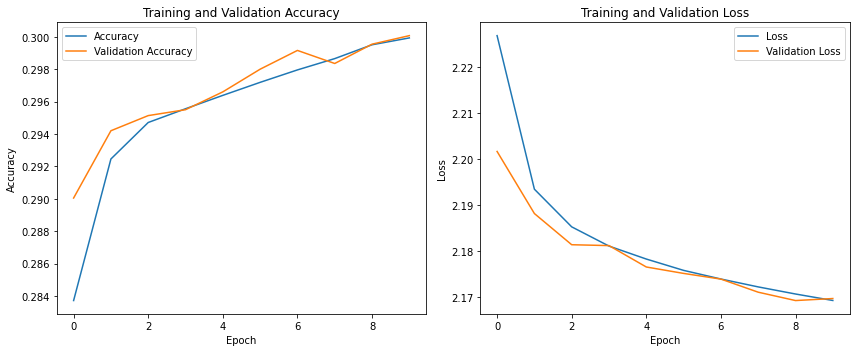

In [102]:
import tensorflow as tf
import json

# Define the model architecture
model_nn = tf.keras.Sequential([
    tf.keras.layers.Dense(128, activation='relu', input_shape=(X_train.shape[1],)),
    tf.keras.layers.Dense(64, activation='relu'),
    # Output layer with the number of units equal to the number of classes, using softmax
    tf.keras.layers.Dense(26, activation='softmax')
])

# Compile the model with sparse categorical crossentropy for integer labels
model_nn.compile(optimizer='adam',
                 loss='sparse_categorical_crossentropy',
                 metrics=['accuracy'])

# Train the model and save the history
history_nn = model_nn.fit(X_train, y_train, epochs=10, validation_data=(X_test, y_test), batch_size=32)

history_json = json.dumps(history_nn.history, indent=4)
with open('neural_net_10_epochs.json', 'w') as f:
    f.write(history_json)

# Plotting the training and validation accuracy
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(history_nn.history['accuracy'], label='Accuracy')
plt.plot(history_nn.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

# Plotting the training and validation loss
plt.subplot(1, 2, 2)
plt.plot(history_nn.history['loss'], label='Loss')
plt.plot(history_nn.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

In [103]:
model_nn_50 = tf.keras.Sequential([
    tf.keras.layers.Dense(128, activation='relu', input_shape=(X_train.shape[1],)),
    tf.keras.layers.Dense(64, activation='relu'),
    # Output layer with the number of units equal to the number of classes, using softmax
    tf.keras.layers.Dense(26, activation='softmax')
])

# Compile the model with sparse categorical crossentropy for integer labels
model_nn_50.compile(optimizer='adam',
                 loss='sparse_categorical_crossentropy',
                 metrics=['accuracy'])

# Train the model and save the history
history_nn_50 = model_nn_50.fit(X_train, y_train, epochs=50, validation_data=(X_test, y_test), batch_size=32)

history_json_50 = json.dumps(history_nn_50.history, indent=4)
with open('neural_net_50_epochs.json', 'w') as f:
    f.write(history_json_50)

Epoch 1/50
78290/78290 [==============================] - 99s 1ms/step - loss: 2.2264 - accuracy: 0.2842 - val_loss: 2.2037 - val_accuracy: 0.2904
Epoch 2/50
78290/78290 [==============================] - 98s 1ms/step - loss: 2.1946 - accuracy: 0.2926 - val_loss: 2.1926 - val_accuracy: 0.2944
Epoch 3/50
78290/78290 [==============================] - 99s 1ms/step - loss: 2.1864 - accuracy: 0.2950 - val_loss: 2.1846 - val_accuracy: 0.2952
Epoch 4/50
78290/78290 [==============================] - 99s 1ms/step - loss: 2.1813 - accuracy: 0.2965 - val_loss: 2.1793 - val_accuracy: 0.2960
Epoch 5/50
78290/78290 [==============================] - 99s 1ms/step - loss: 2.1782 - accuracy: 0.2978 - val_loss: 2.1760 - val_accuracy: 0.2983
Epoch 6/50
78290/78290 [==============================] - 99s 1ms/step - loss: 2.1756 - accuracy: 0.2985 - val_loss: 2.1771 - val_accuracy: 0.2981
Epoch 7/50
78290/78290 [==============================] - 99s 1ms/step - loss: 2.1734 - accuracy: 0.2993 - val_loss: 2

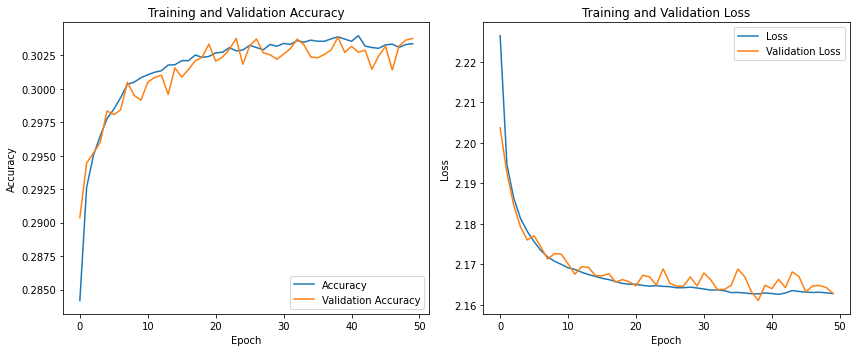

In [108]:
# Plotting the training and validation accuracy
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(history_json_50['accuracy'], label='Accuracy')
plt.plot(history_json_50['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

# Plotting the training and validation loss
plt.subplot(1, 2, 2)
plt.plot(history_json_50['loss'], label='Loss')
plt.plot(history_json_50['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

In [115]:
model_nn_50.save('neural_net_pre_smote.h5')
model_nn_50.save_weights('neural_net_pre_smote_weights.h5')

## After SMOTE:

Overfits like crazy

In [117]:
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split

# Using SMOTE; We have to adjust target column
# Assuming 'data' is your DataFrame and 'target' is the column with class labels; what is the target column for our DataFrame
X = data.iloc[:, 1:]  # Features
y = data.iloc[:, 0]

# Splitting the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Applying SMOTE
smote = SMOTE()
X_train_smote, y_train_smote = smote.fit_resample(X_train, y_train)

#Crime Classification:
X_train_encoded_smoted = feature_data_pipeline.fit_transform(X_train_smote)
X_test_encoded = feature_data_pipeline.transform(X_test)

In [118]:
X_train_encoded_smoted.shape, y_train_smote.shape, X_test_encoded.shape, y_test.shape

((15856750, 9), (15856750,), (626315, 9), (626315,))

In [119]:
gc.collect()

525

In [120]:
model_nn_50_smote = tf.keras.Sequential([
    tf.keras.layers.Dense(128, activation='relu', input_shape=(X_train.shape[1],)),
    tf.keras.layers.Dense(64, activation='relu'),
    # Output layer with the number of units equal to the number of classes, using softmax
    tf.keras.layers.Dense(26, activation='softmax')
])

# Compile the model with sparse categorical crossentropy for integer labels
model_nn_50_smote.compile(optimizer='adam',
                 loss='sparse_categorical_crossentropy',
                 metrics=['accuracy'])

# Train the model and save the history
history_nn_50_smote = model_nn_50.fit(X_train_encoded_smoted, y_train_smote, epochs=50, 
                                      validation_data=(X_test_encoded, y_test), batch_size=32)

history_nn_50_smote = json.dumps(history_nn_50_smote.history, indent=4)
with open('neural_net_50_epochs_smote.json', 'w') as f:
    f.write(history_nn_50_smote)

Epoch 1/50
495524/495524 [==============================] - 557s 1ms/step - loss: 2.5374 - accuracy: 0.2664 - val_loss: 2.8773 - val_accuracy: 0.1193
Epoch 2/50
495524/495524 [==============================] - 548s 1ms/step - loss: 2.5123 - accuracy: 0.2720 - val_loss: 2.8986 - val_accuracy: 0.1187
Epoch 3/50
495524/495524 [==============================] - 551s 1ms/step - loss: 2.5060 - accuracy: 0.2736 - val_loss: 2.8466 - val_accuracy: 0.1282
Epoch 4/50
495524/495524 [==============================] - 551s 1ms/step - loss: 2.5019 - accuracy: 0.2743 - val_loss: 2.8568 - val_accuracy: 0.1242
Epoch 5/50
495524/495524 [==============================] - 551s 1ms/step - loss: 2.5004 - accuracy: 0.2746 - val_loss: 2.8411 - val_accuracy: 0.1315
Epoch 6/50
495524/495524 [==============================] - 550s 1ms/step - loss: 2.4996 - accuracy: 0.2747 - val_loss: 2.8680 - val_accuracy: 0.1240
Epoch 7/50
495524/495524 [==============================] - 550s 1ms/step - loss: 2.4991 - accuracy:

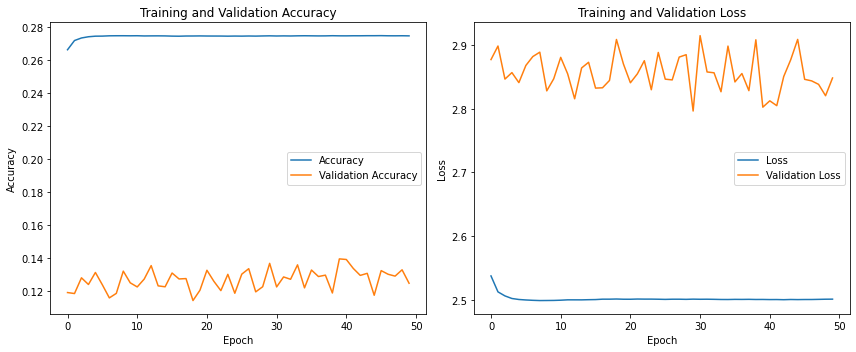

In [123]:
history_nn_50_smote = json.loads(history_nn_50_smote)

# Plotting the training and validation accuracy
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(history_nn_50_smote['accuracy'], label='Accuracy')
plt.plot(history_nn_50_smote['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

# Plotting the training and validation loss
plt.subplot(1, 2, 2)
plt.plot(history_nn_50_smote['loss'], label='Loss')
plt.plot(history_nn_50_smote['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

In [124]:
model_nn_50_smote.save('neural_net_smote.h5')
model_nn_50_smote.save_weights('neural_net_smote_weights.h5')

# Transformer

### Multi-head attention Encoder --> Feedforward Neural Net Dense Layers
We only need a decoder if we're going generation like with GenAI

Our Transformer works with our features as 1d vectors from batch/sample $i$ and feature $j$ $$[f_{i, j}]$$ with input shape **(batch, feature_dimension/sequence size, feature)**

In [139]:
streetnames = pd.read_csv('cartodb-query.csv')["location_block"]
streetnames.dropna(inplace=True)
streetnames

0            2100 BLOCK N BROAD ST
1             4100 BLOCK GREEBY ST
2             2100 BLOCK S 67TH ST
3          3200 BLOCK N NEWKIRK ST
4           5200 BLOCK N HOWARD ST
                    ...           
3177847        400 BLOCK S 55TH ST
3177848      S 08TH ST  / SOUTH ST
3177849       5500 BLOCK CHERRY ST
3177850      S 08TH ST  / SOUTH ST
3177851    5700 BLOCK  RACE STREET
Name: location_block, Length: 3177687, dtype: object

In [142]:
len(streetnames.unique())

148591

In [157]:
gc.collect()

11632

In [143]:
from sklearn.model_selection import train_test_split

# Using SMOTE; We have to adjust target column
# Assuming 'data' is your DataFrame and 'target' is the column with class labels; what is the target column for our DataFrame
X = data.iloc[:, 1:]  # Features
y = data.iloc[:, 0]

# Splitting the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

#Crime Classification:
X_train = feature_data_pipeline.fit_transform(X_train)
X_test = feature_data_pipeline.transform(X_test)

In [144]:
X_train_expanded = tf.expand_dims(X_train, axis=1)
X_test_expanded = tf.expand_dims(X_test, axis=1)

In [145]:
X_train_expanded.shape, y_train.shape, X_test_expanded.shape, y_test.shape

(TensorShape([2505256, 1, 9]),
 (2505256,),
 TensorShape([626315, 1, 9]),
 (626315,))

In [148]:
from tensorflow.keras.layers import MultiHeadAttention, LayerNormalization, Dropout

# Simple Transformer Block
def transformer_block(inputs, head_size, num_heads, ff_dim, dropout=0):
    # Attention and Normalization
    attention_output = MultiHeadAttention(num_heads=num_heads, key_dim=head_size, dropout=dropout)(inputs, inputs)
    attention_output = Dropout(dropout)(attention_output)
    proj_input = LayerNormalization(epsilon=1e-6)(inputs + attention_output)

    # Feed Forward Part
    ffn_output = tf.keras.layers.Dense(ff_dim, activation="relu")(proj_input)
    ffn_output = tf.keras.layers.Dense(inputs.shape[-1])(ffn_output)
    ffn_output = Dropout(dropout)(ffn_output)
    return LayerNormalization(epsilon=1e-6)(proj_input + ffn_output)

# Build the Model
input_layer = tf.keras.layers.Input(shape=(1, X_train.shape[1]))
x = transformer_block(input_layer, head_size=64, num_heads=2, ff_dim=128, dropout=0.1)
x = tf.keras.layers.GlobalAveragePooling1D()(x)
output_layer = tf.keras.layers.Dense(26, activation='softmax')(x)

model_transformer = tf.keras.models.Model(inputs=input_layer, outputs=output_layer)

model_transformer.compile(optimizer='adam',
                          loss='sparse_categorical_crossentropy',
                          metrics=['accuracy'])

# Train the model
history_transformer = model_transformer.fit(X_train_expanded, y_train, epochs=50, 
                                            validation_data=(X_test_expanded, y_test), batch_size=32)
history_transformer = json.dumps(history_transformer.history, indent=4)
with open('transformer_pre_smote.json', 'w') as f:
    f.write(history_transformer)
model_transformer.save('transformer_pre_smote.h5')
model_transformer.save_weights('transformer_pre_smote_weights.h5')

Epoch 1/50
78290/78290 [==============================] - 183s 2ms/step - loss: 2.2900 - accuracy: 0.2699 - val_loss: 2.2469 - val_accuracy: 0.2792
Epoch 2/50
78290/78290 [==============================] - 183s 2ms/step - loss: 2.2672 - accuracy: 0.2758 - val_loss: 2.2334 - val_accuracy: 0.2857
Epoch 3/50
78290/78290 [==============================] - 182s 2ms/step - loss: 2.2601 - accuracy: 0.2773 - val_loss: 2.2359 - val_accuracy: 0.2844
Epoch 4/50
78290/78290 [==============================] - 183s 2ms/step - loss: 2.2558 - accuracy: 0.2786 - val_loss: 2.2283 - val_accuracy: 0.2851
Epoch 5/50
78290/78290 [==============================] - 182s 2ms/step - loss: 2.2526 - accuracy: 0.2792 - val_loss: 2.2211 - val_accuracy: 0.2885
Epoch 6/50
78290/78290 [==============================] - 181s 2ms/step - loss: 2.2504 - accuracy: 0.2797 - val_loss: 2.2211 - val_accuracy: 0.2874
Epoch 7/50
78290/78290 [==============================] - 183s 2ms/step - loss: 2.2488 - accuracy: 0.2803 - val_

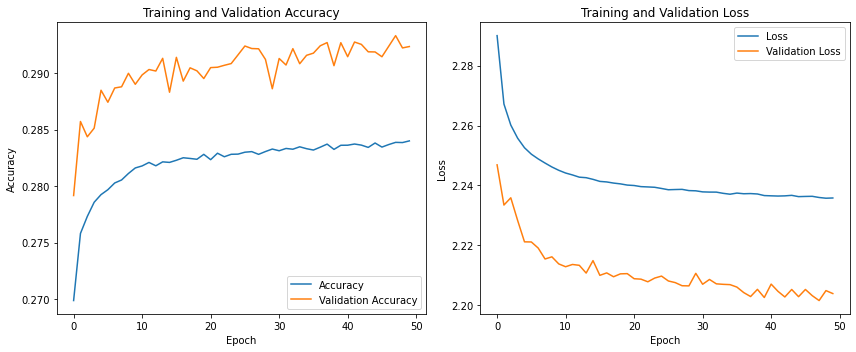

In [149]:
history_transformer = json.loads(history_transformer)

# Plotting the training and validation accuracy
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(history_transformer['accuracy'], label='Accuracy')
plt.plot(history_transformer['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

# Plotting the training and validation loss
plt.subplot(1, 2, 2)
plt.plot(history_transformer['loss'], label='Loss')
plt.plot(history_transformer['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

### Better validation performance is caused by the dropout layers

In [151]:
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split

# Using SMOTE; We have to adjust target column
# Assuming 'data' is your DataFrame and 'target' is the column with class labels; what is the target column for our DataFrame
X = data.iloc[:, 1:]  # Features
y = data.iloc[:, 0]

# Splitting the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Applying SMOTE
smote = SMOTE()
X_train_smote, y_train_smote = smote.fit_resample(X_train, y_train)

#Crime Classification:
X_train_encoded_smoted = feature_data_pipeline.fit_transform(X_train_smote)
X_test_encoded = feature_data_pipeline.transform(X_test)

X_train_expanded = tf.expand_dims(X_train_encoded_smoted, axis=1)
X_test_expanded = tf.expand_dims(X_test_encoded, axis=1)

In [154]:
X_train_expanded.shape, y_train_smote.shape, X_test_expanded.shape, y_test.shape

(TensorShape([15856750, 1, 9]),
 (15856750,),
 TensorShape([626315, 1, 9]),
 (626315,))

In [155]:
from tensorflow.keras.layers import MultiHeadAttention, LayerNormalization, Dropout

# Simple Transformer Block
def transformer_block(inputs, head_size, num_heads, ff_dim, dropout=0):
    # Attention and Normalization
    attention_output = MultiHeadAttention(num_heads=num_heads, key_dim=head_size, dropout=dropout)(inputs, inputs)
    attention_output = Dropout(dropout)(attention_output)
    proj_input = LayerNormalization(epsilon=1e-6)(inputs + attention_output)

    # Feed Forward Part
    ffn_output = tf.keras.layers.Dense(ff_dim, activation="relu")(proj_input)
    ffn_output = tf.keras.layers.Dense(inputs.shape[-1])(ffn_output)
    ffn_output = Dropout(dropout)(ffn_output)
    return LayerNormalization(epsilon=1e-6)(proj_input + ffn_output)

# Build the Model
input_layer = tf.keras.layers.Input(shape=(1, X_train.shape[1]))
x = transformer_block(input_layer, head_size=64, num_heads=2, ff_dim=128, dropout=0.1)
x = tf.keras.layers.GlobalAveragePooling1D()(x)
output_layer = tf.keras.layers.Dense(26, activation='softmax')(x)

model_transformer_smote = tf.keras.models.Model(inputs=input_layer, outputs=output_layer)

model_transformer_smote.compile(optimizer='adam',
                          loss='sparse_categorical_crossentropy',
                          metrics=['accuracy'])

# Train the model
history_transformer_smote = model_transformer_smote.fit(X_train_expanded, y_train_smote, epochs=50, 
                                            validation_data=(X_test_expanded, y_test), batch_size=32)
history_transformer_smote = json.dumps(history_transformer_smote.history, indent=4)
with open('transformer_smote.json', 'w') as f:
    f.write(history_transformer_smote)
model_transformer_smote.save('transformer_smote.h5')
model_transformer_smote.save_weights('transformer_smote_weights.h5')

Epoch 1/50
495524/495524 [==============================] - 1031s 2ms/step - loss: 2.7171 - accuracy: 0.2226 - val_loss: 3.0053 - val_accuracy: 0.0630
Epoch 2/50
495524/495524 [==============================] - 1049s 2ms/step - loss: 2.6900 - accuracy: 0.2302 - val_loss: 2.9975 - val_accuracy: 0.0707
Epoch 3/50
495524/495524 [==============================] - 1040s 2ms/step - loss: 2.6846 - accuracy: 0.2320 - val_loss: 2.9864 - val_accuracy: 0.0726
Epoch 4/50
495524/495524 [==============================] - 1043s 2ms/step - loss: 2.6819 - accuracy: 0.2327 - val_loss: 2.9555 - val_accuracy: 0.0816
Epoch 5/50
495524/495524 [==============================] - 1040s 2ms/step - loss: 2.6804 - accuracy: 0.2333 - val_loss: 2.9847 - val_accuracy: 0.0777
Epoch 6/50
495524/495524 [==============================] - 1043s 2ms/step - loss: 2.6792 - accuracy: 0.2336 - val_loss: 2.9628 - val_accuracy: 0.0804
Epoch 7/50
495524/495524 [==============================] - 47699s 96ms/step - loss: 2.6784 - 

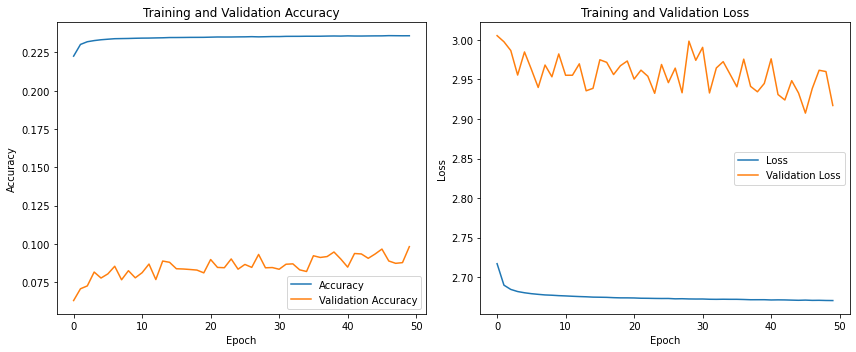

In [156]:
history_transformer_smote = json.loads(history_transformer_smote)

# Plotting the training and validation accuracy
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(history_transformer_smote['accuracy'], label='Accuracy')
plt.plot(history_transformer_smote['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

# Plotting the training and validation loss
plt.subplot(1, 2, 2)
plt.plot(history_transformer_smote['loss'], label='Loss')
plt.plot(history_transformer_smote['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()